# INFORMACIÓN DEL PROYECTO

Tratamos de averiguar qué variables inciden en si un préstamo va a ser impagado

### HIPÓTESIS

La hipótesis de la que partimos es que existen variables que permiten explicar la probabilidad de que un préstamo resulte impagado. 

En concreto partimos de datasets cuyo origen está en el reconocido "All Lending Club loan data" que recopila información sobre diversas variables de préstamos de USA. En Kaggle existe información hasta 2018 (https://www.kaggle.com/datasets/wordsforthewise/lending-club). Para obtener información más actualizada, habría que ser miembro del Club y obtenerla directamente (https://www.lendingclub.com/). Sin emabrgo, dada la longitud y tamaño de la base de datos (más de 1 GB) usaremos un dataset más reducido con datos de 2012 y que usan, a modo de ejemplo, para el servicio SageMaker de Amazon Web Services (AWS).

Los datos se componen de 2 dataset en formato csv con las siguientes columnas.

Dataset 1:

* id: número de identificación del préstamo
* loan_status: estado actual del préstamo (normalmente 3 estados: fully paid, charged off, current)
* loan_amount: importe concedido del préstamo
* funded_amount_by_investors: monto recibido efectivamente por el prestatario (deducidas las comisiones de apertura)
* loan_term: número de pagos del préstamo en meses (36 o 60)
* interest_rate: tipo de interés del préstamo
* installment: cuota mensual del préstamo
* grade: grado clasificación dado por LC (Lending Club)
* subgrade: subgrado otorgado por LC
* verification_status: indica si los ingresos del prestatario han sido verificados por LC
* issued_on: fecha de emisión del préstamo
* purpose: propósito del préstamo (coche, negocio, tarjeta, etc)
* dti: ratio que divide el pago total de cuotas en préstamos del prestatario sobre el total de ingresos mensuales, excluyendo el pago de la hipoteca.
* inquiries_last_six_months: númeo de consultas del prestatario en los últimos 6 meses
* open_credit_lines: número de préstamos del prestatario abiertas.
* derogatory_public_records: número de registros públicos negativos
* revolving_line_utilization_rate: tasa de uso de crédito en tarjetas revolving
* total_credit_lines: total de créditos del pretatario en la base de datos

Dataset 2:

* id: número de identificación del préstamo
* employment_length: tiempo que el prestario ha estado trabajando en años (entre 0 y 10, si es más se le asigna 10)
* employer_title: nombre del empleo del prestatario
* home_ownership: (own= vivienda en propiedad, rent: alquilada)
* annual_income: ingresos anuales del prestatario

Ambos dataset tienen 39717 filas de datos

#### Hipótesis de nuestro proyecto

En nuestro poyecto nos centraremos en averiguar si existe alguna variable o conjunto de variables que expliquen mejor que otras la probabilidad de que un préstamo sea impagado. En concreto, nos centraremos en el estudio de las siguientes variables que podrían explicar el impago del préstamo:

1. El importe del préstamo
2. El tipo de interés aplicado
3. El importe de la cuota
4. El ratio dti (cuotas pagadas en préstamo / ingresos totales)
5. El grado de uso del crédito en tarjetas revolving
6. El tiempo que lleva empleado.
7. Si tiene una casa en propiedad o alquilada
8. El propósito para el que se concedió el préstamo
9. Los ingresos anuales del prestatario.

## OBTENCIÓN DE LOS DATOS

### DATASETS Y FUENTES ALTERNATIVAS DE DATOS

Los datos están disponibles en la web del servicio de Amazon SageMaker de AWS como ejemplo para la demostración de sus servicios.

En concreto las url de cada dataset son las siguientes:

[Dataset 1](https://static.us-east-1.prod.workshops.aws/public/794937ea-b720-4c4b-821c-6535c6b64079/static/datasets/loans-part-1.csv)

[Dataset 2](https://static.us-east-1.prod.workshops.aws/public/794937ea-b720-4c4b-821c-6535c6b64079/static/datasets/loans-part-2.csv)

In [1]:
# Importamos las librerías Python que vamos a necesitar en nuestro estudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import sys
sys.path.append('../')
from utils.eda_functions import *


Empezamos viendo el contenido de cada uno de los dataset (columnas, tipo de datos en cada columna, posible existencia de valores nulos o el número de filas de cada dataset)

In [2]:
df_normal_1 = pd.read_csv('../data/raw/loans-part-1.csv')
df_normal_2 = pd.read_csv('../data/raw/loans-part-2.csv')

In [3]:
df_normal_1.shape

(39717, 18)

In [4]:
df_normal_2.shape

(39717, 5)

In [5]:
df_normal_1.columns

Index(['id', 'loan_status', 'loan_amount', 'funded_amount_by_investors',
       'loan_term', 'interest_rate', 'installment', 'grade', 'sub_grade',
       'verification_status', 'issued_on', 'purpose', 'dti',
       'inquiries_last_6_months', 'open_credit_lines',
       'derogatory_public_records', 'revolving_line_utilization_rate',
       'total_credit_lines'],
      dtype='object')

In [6]:
df_normal_2.columns

Index(['id', 'employment_length', 'employer_title', 'home_ownership',
       'annual_income'],
      dtype='object')

In [7]:
df_normal_1.index == df_normal_2.index

array([ True,  True,  True, ...,  True,  True,  True])

De este primer análisis, parece inferirse que el dataset 2 es una continuación del dataset 1, y que parece tener los mismos id. 

Comprobamos que las columnas id de ambos dataset son iguales

In [8]:
if df_normal_1.index.equals(df_normal_2.index):
    print('Ambos dataset tienen exactamente los mismos índices')
else:
    print('Los dataset no tienen los mismos índices')

Ambos dataset tienen exactamente los mismos índices


Comprobado que efectivamente ambos dataset tienen los mismos índices, procedemos a hacer un merge de los mismos para trabajar con un solo Dataframe

In [9]:
pd.set_option('display.max_columns', None)
df_loans0 = df_normal_1.merge(df_normal_2, on='id')
df_loans0.head(10)

,id,loan_status,loan_amount,funded_amount_by_investors,loan_term,interest_rate,installment,grade,sub_grade,verification_status,issued_on,purpose,dti,inquiries_last_6_months,open_credit_lines,derogatory_public_records,revolving_line_utilization_rate,total_credit_lines,employment_length,employer_title,home_ownership,annual_income
0,1077501,fully paid,5000,4975.0,36,10.65,162.87,b,b2,verified,2011-12-01,credit_card,27.65,1,3,0,83.7,9,10.0,NaN,rent,24000.0
1,1077430,charged off,2500,2500.0,60,15.27,59.83,c,c4,source verified,2011-12-01,car,1.00,5,3,0,9.4,4,1.0,ryder,rent,30000.0
2,1077175,fully paid,2400,2400.0,36,15.96,84.33,c,c5,not verified,2011-12-01,small_business,8.72,2,2,0,98.5,10,10.0,NaN,rent,12252.0
3,1076863,fully paid,10000,10000.0,36,13.49,339.31,c,c1,source verified,2011-12-01,other,20.00,1,10,0,21.0,37,10.0,air resources board,rent,49200.0
4,1075358,current,3000,3000.0,60,12.69,67.79,b,b5,source verified,2011-12-01,other,17.94,0,15,0,53.9,38,1.0,university medical group,rent,80000.0
5,1075269,fully paid,5000,5000.0,36,7.90,156.46,a,a4,source verified,2011-12-01,wedding,11.20,3,9,0,28.3,12,3.0,veolia transportaton,rent,36000.0
6,1069639,fully paid,7000,7000.0,60,15.96,170.08,c,c5,not verified,2011-12-01,debt_consolidation,23.51,1,7,0,85.6,11,8.0,southern star photography,rent,47004.0
7,1072053,fully paid,3000,3000.0,36,18.64,109.43,e,e1,source verified,2011-12-01,car,5.35,2,4,0,87.5,4,9.0,mkc accounting,rent,48000.0
8,1071795,charged off,5600,5600.0,60,21.28,152.39,f,f2,source verified,2011-12-01,small_business,5.55,2,11,0,32.6,13,4.0,NaN,own,40000.0
9,1071570,charged off,5375,5350.0,60,12.69,121.45,b,b5,verified,2011-12-01,other,18.08,0,2,0,36.5,3,1.0,starbucks,rent,15000.0


Vemos algunos datos de este dataset.

In [10]:
df_loans0.shape

(39717, 22)

In [11]:
df_loans0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               39717 non-null  int64  
 1   loan_status                      39717 non-null  object 
 2   loan_amount                      39717 non-null  int64  
 3   funded_amount_by_investors       39717 non-null  float64
 4   loan_term                        39717 non-null  int64  
 5   interest_rate                    39717 non-null  float64
 6   installment                      39717 non-null  float64
 7   grade                            39717 non-null  object 
 8   sub_grade                        39717 non-null  object 
 9   verification_status              39717 non-null  object 
 10  issued_on                        39717 non-null  object 
 11  purpose                          39717 non-null  object 
 12  dti               

Veamos la cardinalidad de las variables no numéricas

In [12]:
for i in df_loans0.select_dtypes(include='object'):
    print(f"La cardinalidad de la variable {i} es {(df_loans0[i].nunique()/df_loans0.shape[0])*100:.2f}%")

La cardinalidad de la variable loan_status es 0.01%
La cardinalidad de la variable grade es 0.02%
La cardinalidad de la variable sub_grade es 0.09%
La cardinalidad de la variable verification_status es 0.01%
La cardinalidad de la variable issued_on es 0.14%
La cardinalidad de la variable purpose es 0.04%
La cardinalidad de la variable employer_title es 68.51%
La cardinalidad de la variable home_ownership es 0.01%


Comprobemos que no hay duplicados en nuestros datos. 

In [13]:
df_loans0.duplicated().sum()

0

Nuestro dataframe no tiene filas duplicadas

Algunas de estas columnas no las vamos a usar en nuestro análisis por considerarlas irrelevantes para el mismo, por lo que decisimos eliminarlas del dataset. En concreto son las siguientes:

* 'funded_amount_by_investors": no es más que el importe del préstamo deduciendo las comisiones. Nos quedamos con el importe total del préstamo
* 'grade': se trata de una clasificación hecha por el Lending Club. No la vamos a tener en cuenta en nuestro análisis
* 'sub_grade': idem al anterior
* 'verification_status': indica si los ingresos del prestatario han sido verificados o no.
* 'issued_on': fecha de emisión del préstamo. Es indiferente a nuestro análisis la fecha en la que el préstamo se aprobó.
* 'inquiries_last_months': Número de veces que se ha consultado el préstamo en la base de datos
* 'open_credit_lines': número de operaciones abiertas por el prestatario. No es una variable que vayamos a estudiar.
* 'derogatory_public_records': número de registros públicos negativos. No lo vamos a tener en cuenta en el análisis.
* 'total_credit_lines': número de créditos del prestatario en la base de datos. 
* 'employer_title': sector del empleador. Tiene mucha cardinalidad, por lo que no es práctico su análisis.

Por otro lado, comprobamos los valores de la columna objeto de todos los estudios que es 'loan_status'

In [14]:
df_loans0['loan_status'].value_counts()

loan_status
fully paid     32950
charged off     5627
current         1140
Name: count, dtype: int64

In [15]:
df_loans0.to_csv('../data/process/loans0.csv', index=False)

Cómo vemos, esta columna tiene 3 posibles valores:
* 'fully_paid': El préstamo ha sido pagado por completo.
* 'charged_off': el préstamo está en una situación de impagado.
* 'current': El préstamo está vigente

De entre todas las opciones, nos quedamos con las 2 primeras, ya que los préstamos vigentes no sabemos si van a ser pagados o no (De hecho, podíamos usar estos datos para hacer un estudio de Machine Learning y comprobar la probabilidad de impago de los mismos)

In [16]:
columnas_eliminar = ['funded_amount_by_investors', 'grade', 'sub_grade', 'verification_status', 'issued_on', 'inquiries_last_6_months', 'open_credit_lines',
                      'derogatory_public_records', 'total_credit_lines', 'employer_title']

df_loans = df_loans0.copy()
df_final = df_loans[df_loans['loan_status'] != 'current'].drop(columnas_eliminar, axis=1)
df_final.rename(columns={'revolving_line_utilization_rate': 'revolving_rate'}, inplace=True)

df_current_final = df_loans[df_loans['loan_status'] == 'current'].drop(columnas_eliminar, axis=1)
df_current_final.rename(columns={'revolving_line_utilization_rate': 'revolving_rate'}, inplace=True)


df_final.head(10)

,id,loan_status,loan_amount,loan_term,interest_rate,installment,purpose,dti,revolving_rate,employment_length,home_ownership,annual_income
0,1077501,fully paid,5000,36,10.65,162.87,credit_card,27.65,83.7,10.0,rent,24000.0
1,1077430,charged off,2500,60,15.27,59.83,car,1.00,9.4,1.0,rent,30000.0
2,1077175,fully paid,2400,36,15.96,84.33,small_business,8.72,98.5,10.0,rent,12252.0
3,1076863,fully paid,10000,36,13.49,339.31,other,20.00,21.0,10.0,rent,49200.0
5,1075269,fully paid,5000,36,7.90,156.46,wedding,11.20,28.3,3.0,rent,36000.0
6,1069639,fully paid,7000,60,15.96,170.08,debt_consolidation,23.51,85.6,8.0,rent,47004.0
7,1072053,fully paid,3000,36,18.64,109.43,car,5.35,87.5,9.0,rent,48000.0
8,1071795,charged off,5600,60,21.28,152.39,small_business,5.55,32.6,4.0,own,40000.0
9,1071570,charged off,5375,60,12.69,121.45,other,18.08,36.5,1.0,rent,15000.0
10,1070078,fully paid,6500,60,14.65,153.45,debt_consolidation,16.12,20.6,5.0,own,72000.0


Así, ya tenemos un dataframe con las columnas que nos interesa y con dos 'loan_status' que nos interesa. Tenemos también otro Dataframe llamado df_current_final con datos de los préstamos vigentes.


Pasamos a hacer un estudio más detallado de las variables de este dataset.

In [17]:
df_final.to_csv('../data/process/df_final.csv', index=False)
df_current_final.to_csv('../data/process/df_current_final.csv', index=False)

In [18]:
df_final.shape

(38577, 12)

In [19]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38577 entries, 0 to 39716
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 38577 non-null  int64  
 1   loan_status        38577 non-null  object 
 2   loan_amount        38577 non-null  int64  
 3   loan_term          38577 non-null  int64  
 4   interest_rate      38577 non-null  float64
 5   installment        38577 non-null  float64
 6   purpose            38577 non-null  object 
 7   dti                38577 non-null  float64
 8   revolving_rate     38527 non-null  float64
 9   employment_length  37544 non-null  float64
 10  home_ownership     38577 non-null  object 
 11  annual_income      38577 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 3.8+ MB


Podemos observar que las columnas 'employment_length' y 'revolving_rate' contiene valores bulos

In [20]:
df_final.describe(exclude='object').round(2)

,id,loan_amount,loan_term,interest_rate,installment,dti,revolving_rate,employment_length,annual_income
count,38577.00,38577.00,38577.00,38577.00,38577.00,38577.00,38527.00,37544.00,38577.00
mean,676378.71,11047.03,41.90,11.93,322.47,13.27,48.70,5.06,68777.97
std,209263.90,7348.44,10.33,3.69,208.64,6.67,28.36,3.40,64218.68
min,54734.00,500.00,36.00,5.42,15.69,0.00,0.00,1.00,4000.00
25%,512033.00,5300.00,36.00,8.94,165.74,8.13,25.20,2.00,40000.00
50%,656423.00,9600.00,36.00,11.71,277.86,13.37,49.10,4.00,58868.00
75%,829146.00,15000.00,36.00,14.38,425.55,18.56,72.30,9.00,82000.00
max,1077501.00,35000.00,60.00,24.40,1305.19,29.99,99.90,10.00,6000000.00


In [21]:
df_final.describe(include='object')

,loan_status,purpose,home_ownership
count,38577,38577,38577
unique,2,14,5
top,fully paid,debt_consolidation,rent
freq,32950,18055,18480


In [22]:
df_final.nunique()

id                   38577
loan_status              2
loan_amount            870
loan_term                2
interest_rate          370
installment          15022
purpose                 14
dti                   2853
revolving_rate        1088
employment_length       10
home_ownership           5
annual_income         5215
dtype: int64

Veamos más detalles de las columnas 'loan_status', 'purpose', 'home_ownership', 'loan_term', y 'employment_length'

In [23]:
df_final['loan_status'].value_counts()

loan_status
fully paid     32950
charged off     5627
Name: count, dtype: int64

In [24]:
df_final['loan_status'].value_counts(normalize=True).mul(100).round(2)

loan_status
fully paid     85.41
charged off    14.59
Name: proportion, dtype: float64

In [25]:
df_final['purpose'].value_counts(normalize=True).mul(100).round(2)

purpose
debt_consolidation    46.80
credit_card           13.03
other                 10.02
home_improvement       7.45
major_purchase         5.57
small_business         4.55
car                    3.89
wedding                2.40
medical                1.77
moving                 1.49
vacation               0.97
house                  0.95
educational            0.84
renewable_energy       0.26
Name: proportion, dtype: float64

In [26]:
df_final['home_ownership'].value_counts(normalize=True).mul(100).round(2)

home_ownership
rent        47.90
mortgage    44.12
own          7.71
other        0.25
none         0.01
Name: proportion, dtype: float64

In [27]:
df_final['loan_term'].value_counts(normalize=True).mul(100).round(2)

loan_term
36    75.42
60    24.58
Name: proportion, dtype: float64

In [28]:
df_final['employment_length'].value_counts(normalize=True).mul(100).round(2)

employment_length
10.0    22.61
1.0     20.45
2.0     11.43
3.0     10.69
4.0      8.90
5.0      8.51
6.0      5.77
7.0      4.56
8.0      3.82
9.0      3.27
Name: proportion, dtype: float64

En este último caso, tenemos que hacer la precisión de que los empleados con 10 años de antigüedad son en realidad de 10 o más años de antigüedad

## Limpieza de datos

### Sustitución de valores nulos

Vamos a analizar ahora las columnas con valores faltantes, en nuestro caso, 'revolving_rate' y 'employment_length'. En el primer caso son 50 de 38.577 filas (0,13%). En el segundo caso son 1.033 de 38.577 (2,68 %)

In [29]:
df_final.isna().sum()

id                      0
loan_status             0
loan_amount             0
loan_term               0
interest_rate           0
installment             0
purpose                 0
dti                     0
revolving_rate         50
employment_length    1033
home_ownership          0
annual_income           0
dtype: int64

Veamos la distribución de ambas columnas

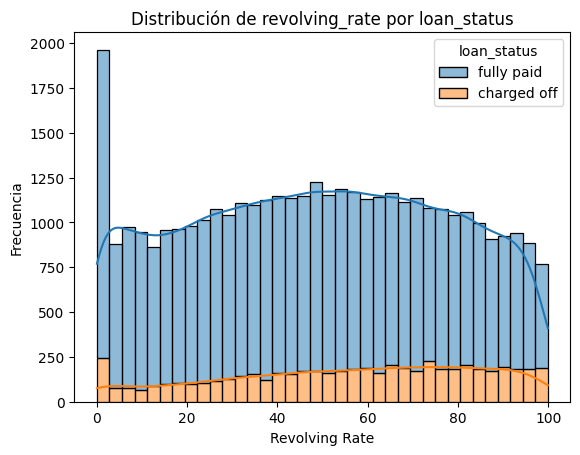

In [30]:
sns.histplot(data=df_final, x='revolving_rate', hue='loan_status', multiple='stack', kde=True);
plt.title('Distribución de revolving_rate por loan_status')
plt.xlabel('Revolving Rate')
plt.ylabel('Frecuencia')
plt.show()

Tenemos muchos datos con el valor 'revolving_rate' = 0 (es decir, que el prestatario no ha incurrido en 'revolving)

In [31]:
tasa_no_revolving = (df_final['revolving_rate'] == 0).sum() / len(df_final) * 100
tasa_no_revolving.round(2)

2.47

In [32]:
df_final['revolving_rate'].value_counts(normalize=True).mul(100).round(2)

revolving_rate
0.00     2.48
0.20     0.16
63.00    0.16
40.70    0.15
31.20    0.15
         ... 
77.63    0.00
25.74    0.00
0.83     0.00
47.36    0.00
7.28     0.00
Name: proportion, Length: 1088, dtype: float64

Vamos a considerar que los valores Nan de la columna 'revolving_rate' son, en realidad, valores con tasa de revolving cero. Sustituimos los valores Nan, por valores cero

In [33]:
df_final['revolving_rate'].fillna(0, inplace=True)


En cuanto a la columna 'employment_lenth', veamos un gráfico con su distribución de valores

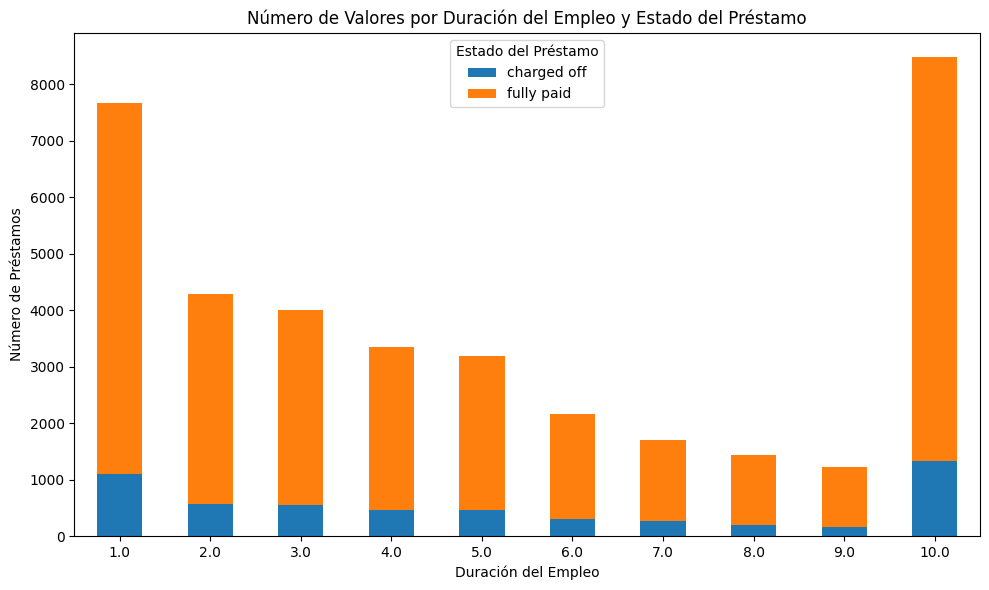

In [34]:
# Conteo de valores de 'employment_length' discriminando por 'loan_status'
pivot_df = df_final.pivot_table(index='employment_length', columns='loan_status', aggfunc='size', fill_value=0)

# Crear el gráfico de barras apiladas
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configuración del gráfico
plt.xlabel('Duración del Empleo')
plt.ylabel('Número de Préstamos')
plt.title('Número de Valores por Duración del Empleo y Estado del Préstamo')
plt.legend(title='Estado del Préstamo')
plt.xticks(rotation=0)  # Rotar etiquetas del eje x si es necesario

# Mostrar el gráfico
plt.tight_layout()
plt.show()

En porcentajes por tipo sobre el total

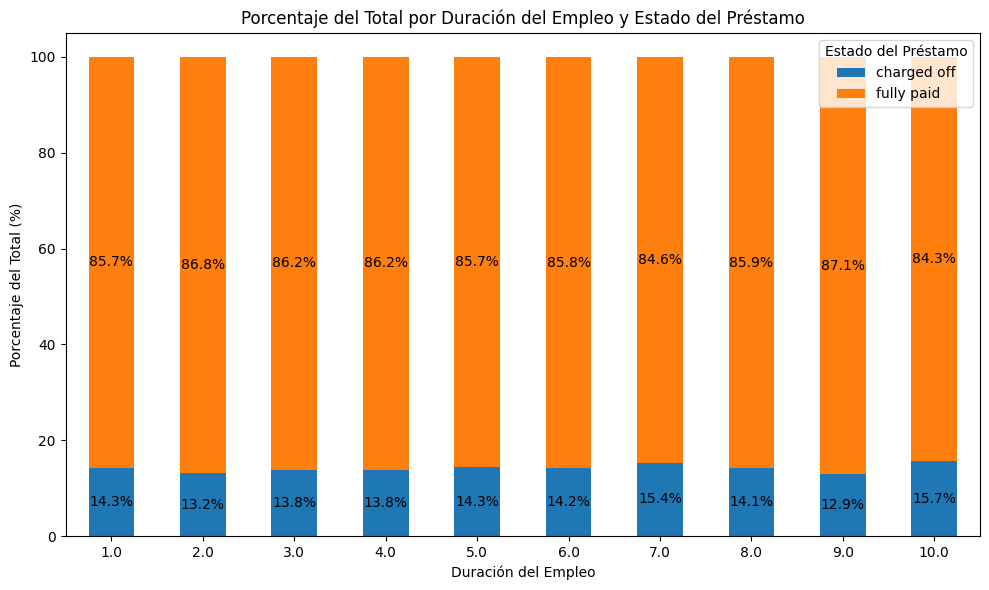

In [35]:
# Conteo de valores de 'employment_length' discriminando por 'loan_status'
pivot_df3 = df_final.pivot_table(index='employment_length', columns='loan_status', aggfunc='size', fill_value=0)

# Calcular los porcentajes
totals = pivot_df3.sum(axis=1)
percentage_df = pivot_df3.div(totals, axis=0) * 100

# Crear el gráfico de barras apiladas con porcentajes y etiquetas
ax = percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configuración del gráfico
plt.xlabel('Duración del Empleo')
plt.ylabel('Porcentaje del Total (%)')
plt.title('Porcentaje del Total por Duración del Empleo y Estado del Préstamo')
plt.legend(title='Estado del Préstamo')
plt.xticks(rotation=0)  # Rotar etiquetas del eje x si es necesario

# Agregar etiquetas con los porcentajes a las barras
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center', color='black')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Veamos ahora un dataset con los datos de 'employment_length' Nan, para ver si podemos establecer algún criterio para asignar estos valores.

In [36]:
df_final[df_final['employment_length'].isna()].head(30)

,id,loan_status,loan_amount,loan_term,interest_rate,installment,purpose,dti,revolving_rate,employment_length,home_ownership,annual_income
168,1067644,charged off,2500,36,7.51,77.78,debt_consolidation,16.30,42.2,NaN,own,12000.0
323,1058717,fully paid,18000,60,17.58,452.98,debt_consolidation,21.96,83.7,NaN,mortgage,60000.0
394,1064582,fully paid,4000,36,11.71,132.31,home_improvement,7.50,54.9,NaN,rent,24000.0
422,1064366,charged off,1000,36,14.65,34.50,major_purchase,6.00,83.7,NaN,rent,18408.0
439,1063912,fully paid,8250,36,7.51,256.67,debt_consolidation,17.87,10.4,NaN,mortgage,31500.0
534,1062897,charged off,1700,36,7.90,53.20,home_improvement,27.00,91.2,NaN,mortgage,37800.0
555,1062781,fully paid,5000,36,8.90,158.77,other,16.17,53.0,NaN,mortgage,70000.0
562,1062535,fully paid,3000,36,9.91,96.68,renewable_energy,4.29,33.3,NaN,mortgage,42000.0
569,1036838,charged off,8575,36,17.58,308.21,debt_consolidation,22.54,89.9,NaN,mortgage,32000.0
678,1061194,fully paid,5600,36,6.03,170.44,car,3.97,2.7,NaN,own,41100.0


No parece haber un criterio claro para asignar los Nan de esta columna. Vamos a proceder a repartir los valores Nan según los porcentajes que representan cada valor, de manera aleatoria. En primer lugar veamos la distribución porcentual de cada valor en la columna.

In [37]:
df_final['employment_length'].value_counts(normalize=True, dropna=True).mul(100).round(2)

employment_length
10.0    22.61
1.0     20.45
2.0     11.43
3.0     10.69
4.0      8.90
5.0      8.51
6.0      5.77
7.0      4.56
8.0      3.82
9.0      3.27
Name: proportion, dtype: float64

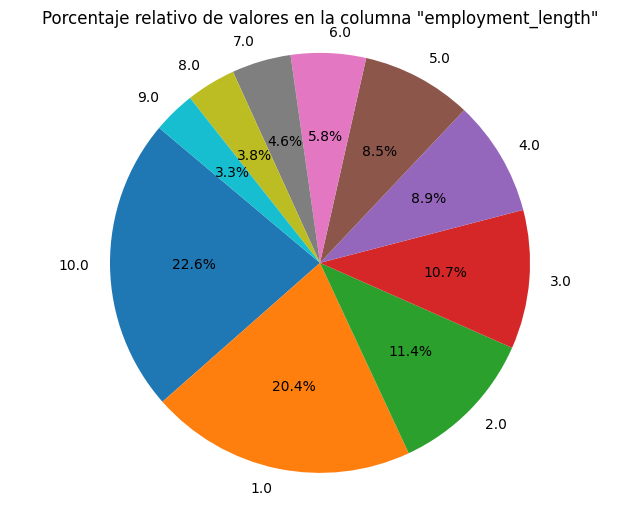

In [38]:
# Obtén la cuenta de cada valor único en la columna 'employment_length'
employment_counts = df_final['employment_length'].value_counts()

# Crea un gráfico tipo pastel
plt.figure(figsize=(8, 6))  # Ajusta el tamaño del gráfico
plt.pie(employment_counts, labels=employment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje relativo de valores en la columna "employment_length"')
plt.axis('equal')  # Hace que el gráfico sea un círculo en lugar de una elipse

# Muestra el gráfico
plt.show()

Procedemos a repartir los valores Nan proporcionalmente a los valores que tiene en el dataframe de manera aleatoria.

In [39]:
# Calcular el porcentaje de cada valor presente en 'employment_length'
porcentaje_valores = df_final['employment_length'].value_counts(normalize=True, dropna=True)

# Determinar el número de valores NaN en 'employment_length'
num_nan_values = df_final['employment_length'].isnull().sum()

# Asignar los valores NaN proporcionalmente
valores_a_asignar = np.random.choice(porcentaje_valores.index, size=num_nan_values, p=porcentaje_valores)

# Actualizar los valores NaN en 'employment_length'
df_final.loc[df_final['employment_length'].isnull(), 'employment_length'] = valores_a_asignar

In [40]:
df_final.isna().sum()

id                   0
loan_status          0
loan_amount          0
loan_term            0
interest_rate        0
installment          0
purpose              0
dti                  0
revolving_rate       0
employment_length    0
home_ownership       0
annual_income        0
dtype: int64

In [41]:
df_final['employment_length'].value_counts(normalize=True).mul(100).round(2)

employment_length
10.0    22.64
1.0     20.42
2.0     11.45
3.0     10.71
4.0      8.88
5.0      8.51
6.0      5.80
7.0      4.53
8.0      3.79
9.0      3.28
Name: proportion, dtype: float64

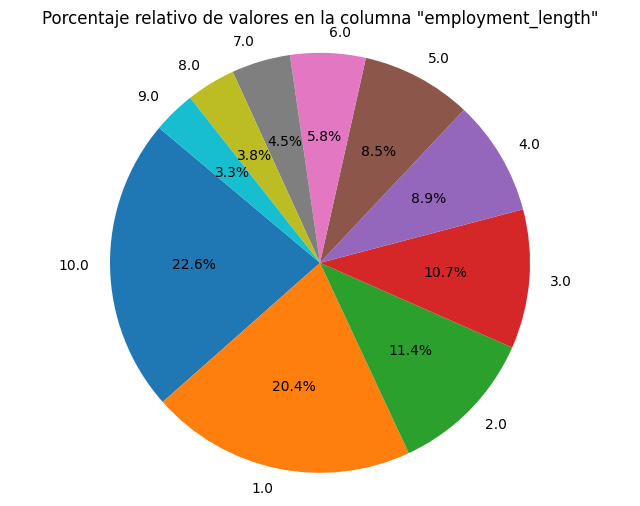

In [42]:
# Obtén la cuenta de cada valor único en la columna 'employment_length'
employment_counts = df_final['employment_length'].value_counts()

# Crea un gráfico tipo pastel
plt.figure(figsize=(8, 6))  # Ajusta el tamaño del gráfico
plt.pie(employment_counts, labels=employment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje relativo de valores en la columna "employment_length"')
plt.axis('equal')  # Hace que el gráfico sea un círculo en lugar de una elipse

# Muestra el gráfico
plt.show()

Vemos que los porcentajes definitivos de esta columna son muy similares a los iniciales, por lo que damos por finalizada la limpieza de datos del EDA.

Una vez que hemos eliminado los valores nulos de la columna 'employment_length'. Procedemos a convertir esta columna en integer, ya que se trata de una variable cuantitativa discreta

In [43]:
df_final['employment_length'] = df_final['employment_length'].astype(int)

### Búsqueda y sustitución de outliers

El siguiente paso es buscar posibles outliers o valores atípicos. Para detectar posibles valores atípicos usamos gráficos de tipo boxplot, en las variables que sean cuantitativas contínuas.

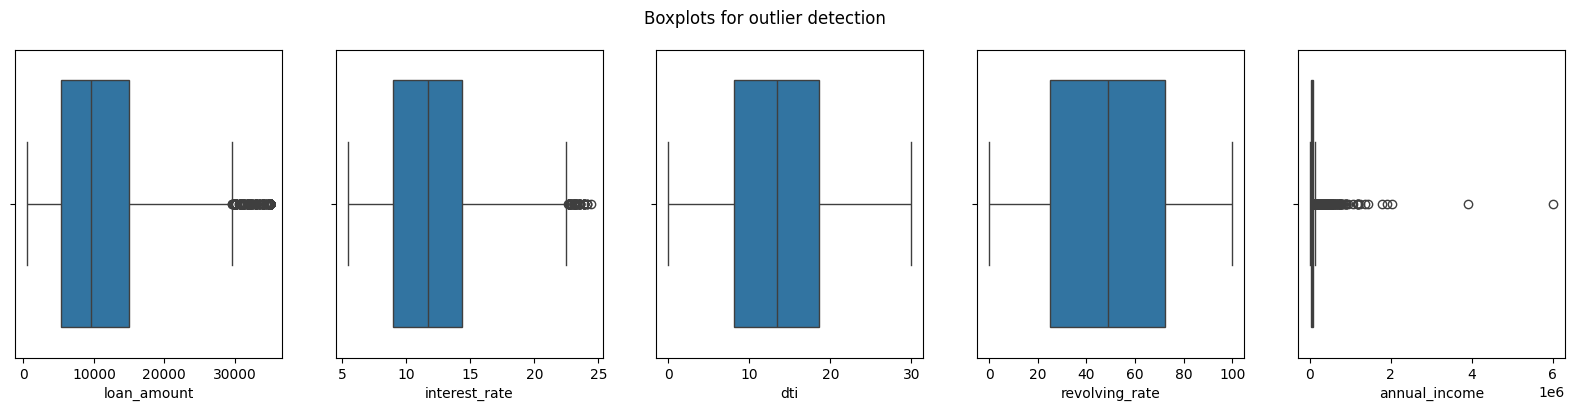

In [44]:
# Filtrar las columnas que contienen variables numéricas continuas
columnas_continuas = ['loan_amount', 'interest_rate', 'dti', 'revolving_rate', 'annual_income']

# Crear boxplots para cada columna continua
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=df_final[columnas_continuas[0]])
sns.boxplot(ax=axes[1], x=df_final[columnas_continuas[1]])
sns.boxplot(ax=axes[2], x=df_final[columnas_continuas[2]])
sns.boxplot(ax=axes[3], x=df_final[columnas_continuas[3]])
sns.boxplot(ax=axes[4], x=df_final[columnas_continuas[4]])
plt.show();

Por la gráfica, vemos que tanto las columnas 'dti' o 'revolving_rate' no tiene outliers apreciables. Las otras 3 columnas, y sobre todo la columna 'annual_income' parecen tener elevados valores fuera del rango del 1,5 * rango intercuartílico

In [45]:
df_final[columnas_continuas].describe().round(2)

,loan_amount,interest_rate,dti,revolving_rate,annual_income
count,38577.00,38577.00,38577.00,38577.00,38577.00
mean,11047.03,11.93,13.27,48.64,68777.97
std,7348.44,3.69,6.67,28.40,64218.68
min,500.00,5.42,0.00,0.00,4000.00
25%,5300.00,8.94,8.13,25.10,40000.00
50%,9600.00,11.71,13.37,49.00,58868.00
75%,15000.00,14.38,18.56,72.20,82000.00
max,35000.00,24.40,29.99,99.90,6000000.00


Vamos a volver a realizar un gráfico boxplot para las columnas 'loan_amount', 'interest_rate' y 'annual_income', pero tomando con outliers la cantidad de 6 veces el rango intercuartílico

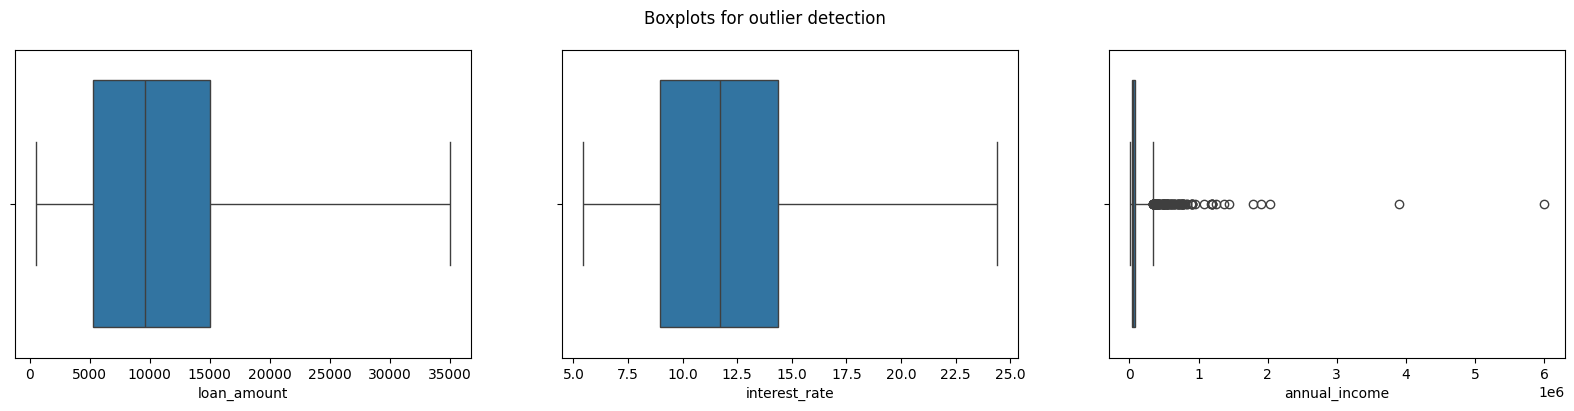

In [46]:
# Filtrar las columnas que contienen variables numéricas continuas
columnas_continuas_2 = ['loan_amount', 'interest_rate', 'annual_income']

# Crear boxplots para cada columna continua
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=df_final[columnas_continuas_2[0]], whis=6)
sns.boxplot(ax=axes[1], x=df_final[columnas_continuas_2[1]], whis=6)
sns.boxplot(ax=axes[2], x=df_final[columnas_continuas_2[2]], whis=6)

plt.show();

Aumentando a 6 las veces del rango intercuartílico para considerar un valor como outlier resolvemos la existencia de outliers en las columnas 'loan_amount' y 'interest_rate', pero seguimos teniendo muchos valores como outliers en la columna 'annual_income'. Vamos a estudiar con detenimiento cuántos valores son y de qué importes estamos hablando en esta columna.

In [47]:
q1_income = df_final['annual_income'].quantile(0.25)
q3_income = df_final['annual_income'].quantile(0.75)
iqr_income = q3_income - q1_income
upper_income = q3_income + 6 * iqr_income
lower_income = q1_income - 6 * iqr_income

In [48]:
df_final[df_final['annual_income'] > upper_income]['annual_income'].describe().round(2)

count        138.00
mean      659263.39
std       620376.83
min       336000.00
25%       384250.00
50%       500000.00
75%       720000.00
max      6000000.00
Name: annual_income, dtype: float64

Vemos que los valores que superan las 6 veces el rango intercuartílico de la columna 'annual_income' son 138 valores de 38.577 (0,3577 %). El importe mínimo de este grupo es de
336.000, y el máximo es de 6.000.000. 
Vamos a optar por asignar a todos los valores de la columna 'annual_income" que superen los 336.000 este valor. 

In [49]:
iqr_factor = 6
q1 = df_final['annual_income'].quantile(0.25)
q3 = df_final['annual_income'].quantile(0.75)
iqr = q3 - q1
upper_threshold = q3 + (iqr_factor * iqr)
print('annul_income')
print('q3:', q3)
print('uumbral superior:', upper_threshold)

# Reassign values > threshold to threshold
df_final.loc[df_final['annual_income'] > upper_threshold, 'annual_income'] = upper_threshold
print(df_final['annual_income'].describe().round(2))

annul_income
q3: 82000.0
uumbral superior: 334000.0
count     38577.00
mean      67614.42
std       41954.37
min        4000.00
25%       40000.00
50%       58868.00
75%       82000.00
max      334000.00
Name: annual_income, dtype: float64


Volvemos a hacer el gráfico de boxplots inicial, pero con un factor 6 por el rango intercuartílico

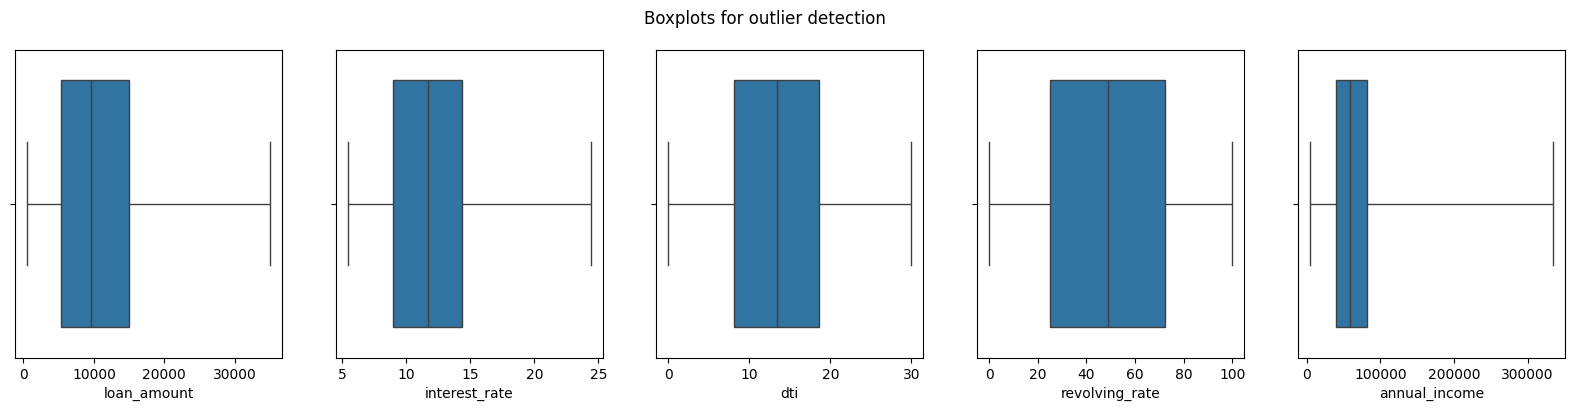

In [50]:
# Filtrar las columnas que contienen variables numéricas continuas
columnas_continuas = ['loan_amount', 'interest_rate', 'dti', 'revolving_rate', 'annual_income']

# Crear boxplots para cada columna continua
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=df_final[columnas_continuas[0]], whis=6)
sns.boxplot(ax=axes[1], x=df_final[columnas_continuas[1]], whis=6)
sns.boxplot(ax=axes[2], x=df_final[columnas_continuas[2]], whis=6)
sns.boxplot(ax=axes[3], x=df_final[columnas_continuas[3]], whis=6)
sns.boxplot(ax=axes[4], x=df_final[columnas_continuas[4]], whis=6)

plt.show();


Vemos que ahora ya no tenemos outliers

In [51]:
df_final_clean = df_final.copy()
df_final_clean.to_csv('../data/process/df_final_clean.csv', index=False)

In [52]:
df_final.to_csv('../data/final/df_final.csv', index=False)

## Análisis

Veamos primero un gráfico pairplot con las principales columnas del dataframe

In [53]:
# columnas_pairplot = ['loan_status', 'loan_amount', 'interest_rate', 'purpose', 
#                     'dti', 'revolving_rate', 'employment_length', 'home_ownership', 'annual_income']

# sns.pairplot(df_final[columnas_pairplot], kind='scatter', hue='loan_status',
#             plot_kws=dict(s=80, edgecolor='white',linewidth=2.5));

De una primera visualización de la relación entre las diferentes variables de nuestro dataframe no parecen inferirse relaciones claras entre las variables, más allá de que algunas 
distribuciones pudieran ser normales.

### Análisis Univariante

Veamos primero un histograma de la variable 'loan_amount', diferenciando gráficamente entre si el préstamo ha sido pagado o no

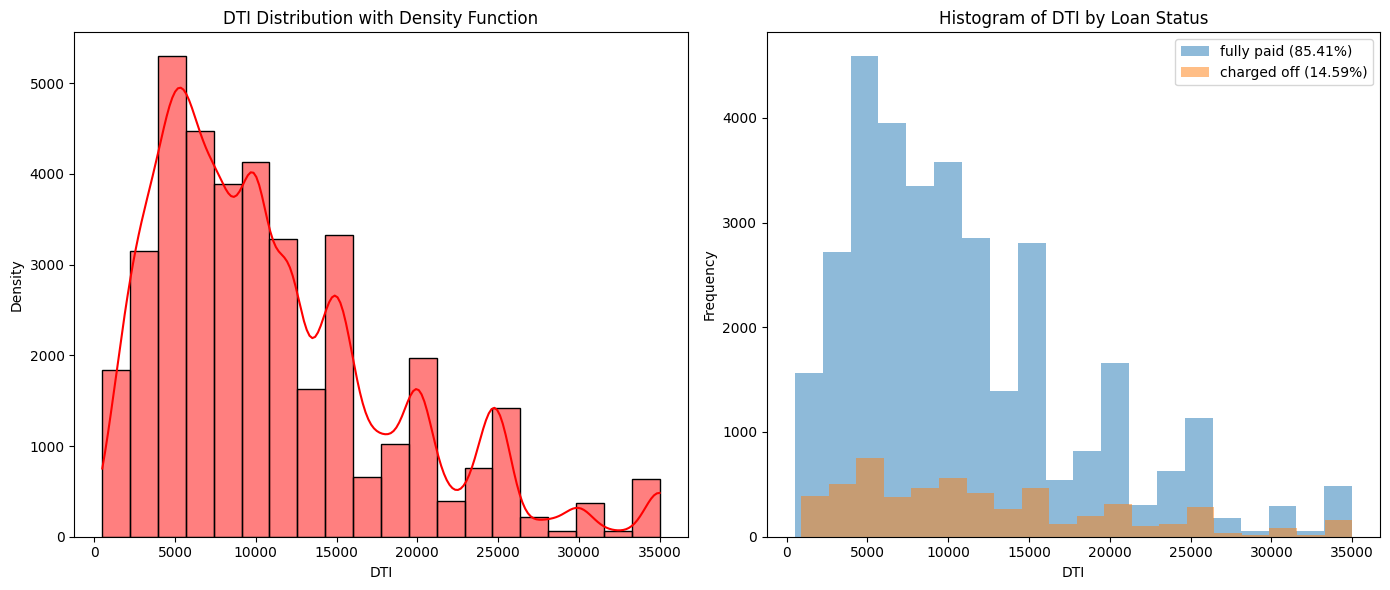

In [54]:
# Crear la figura y las subtramas en 1 fila y 2 columnas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Primer gráfico: histograma con función de densidad usando Seaborn
sns.histplot(df_final['loan_amount'], kde=True, bins=20, color='red', ax=ax1)
ax1.set_xlabel('DTI')
ax1.set_ylabel('Density')
ax1.set_title('DTI Distribution with Density Function')

# Segundo gráfico: histograma de 'loan_amount' por 'loan_status'
status_counts = df_final['loan_status'].value_counts(normalize=True) * 100

for status in df_final['loan_status'].unique():
    loan_amounts = df_final[df_final['loan_status'] == status]['loan_amount']
    ax2.hist(loan_amounts, bins=20, alpha=0.5, label=f"{status} ({status_counts[status]:.2f}%)")

ax2.set_xlabel('DTI')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of DTI by Loan Status')
ax2.legend()

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos combinados
plt.show()

Del gráfico no podemos inferir una relación clara entre el tipo de interés aplicado y el impago de un préstamo

Veamos ahora el gráfico de barras para la columna 'loan_term', diferenciando si el préstamo ha sido pagado o no

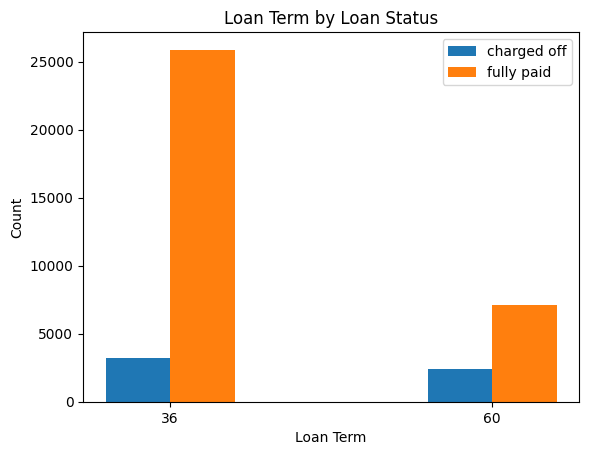

In [55]:
# Crear el gráfico de barras agrupado
fig, ax = plt.subplots()

# Agrupar los datos por 'loan_status' y contar los valores de 'loan_term'
grouped = df_final.groupby('loan_status')['loan_term'].value_counts().unstack()

index = range(len(grouped.columns))
bar_width = 0.2

# Iterar sobre cada 'loan_status' y dibujar una barra para cada valor de 'loan_term'
for i, status in enumerate(grouped.index):
    ax.bar([x + i * bar_width for x in index], grouped.loc[status], bar_width, label=status)

# Añadir etiquetas, título y leyenda
ax.set_xlabel('Loan Term')
ax.set_ylabel('Count')
ax.set_title('Loan Term by Loan Status')
ax.set_xticks([x + (len(grouped.index) - 1) * bar_width / 2 for x in index])
ax.set_xticklabels(grouped.columns)
ax.legend()

# Mostrar el gráfico de barras agrupado
plt.show()

In [56]:
# Porcentajes relativos de cada valor de 'loan_status' por cada valor de 'loan_term'
grouped = df_final.groupby('loan_term')['loan_status'].value_counts(normalize=True).unstack() * 100

print(grouped)

loan_status  charged off  fully paid
loan_term                           
36             11.090872   88.909128
60             25.313785   74.686215


Creamos el mapa de calor

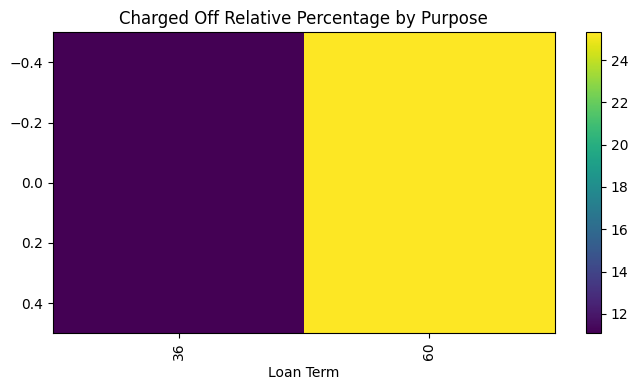

In [57]:
# Filtrar el DataFrame para 'loan_status' igual a 'charged off'
charged_off_df = df_final[df_final['loan_status'] == 'charged off']

# Obtener el recuento de combinaciones 'purpose'-'loan_status' igual a 'charged off'
grouped = charged_off_df.groupby('loan_term')['loan_status'].count()

# Calcular los porcentajes relativos para cada valor de 'purpose'
relative_percentages = (grouped / df_final['loan_term'].value_counts()) * 100

# Crear un DataFrame con los porcentajes relativos
relative_percentages_df = pd.DataFrame(relative_percentages, columns=['Charged Off Relative Percentage'])

# Crear un gráfico de calor
plt.figure(figsize=(7, 4))
heatmap = plt.imshow(relative_percentages_df.values.reshape(1, -1), aspect='auto')

# Añadir etiquetas, título y colorbar
plt.xticks(range(len(relative_percentages_df)), relative_percentages_df.index, rotation=90)
plt.xlabel('Loan Term')
plt.ylabel('')
plt.title('Charged Off Relative Percentage by Purpose')
plt.colorbar(heatmap)

plt.tight_layout()
plt.show()

Aquí tenemos una conclusión interente. El índice de créditos impagados sube mucho cuando el plazo de pago pasa de 36 meses a 60 meses. En concreto, 25,31% de los créditos a 60 meses resulta impagado, frente al 11 % de los créditos a 36 meses.

Pasamos ahora a hacer un histograma de los tipos de interés mostrando los valores si el préstamo ha sido pagado o no

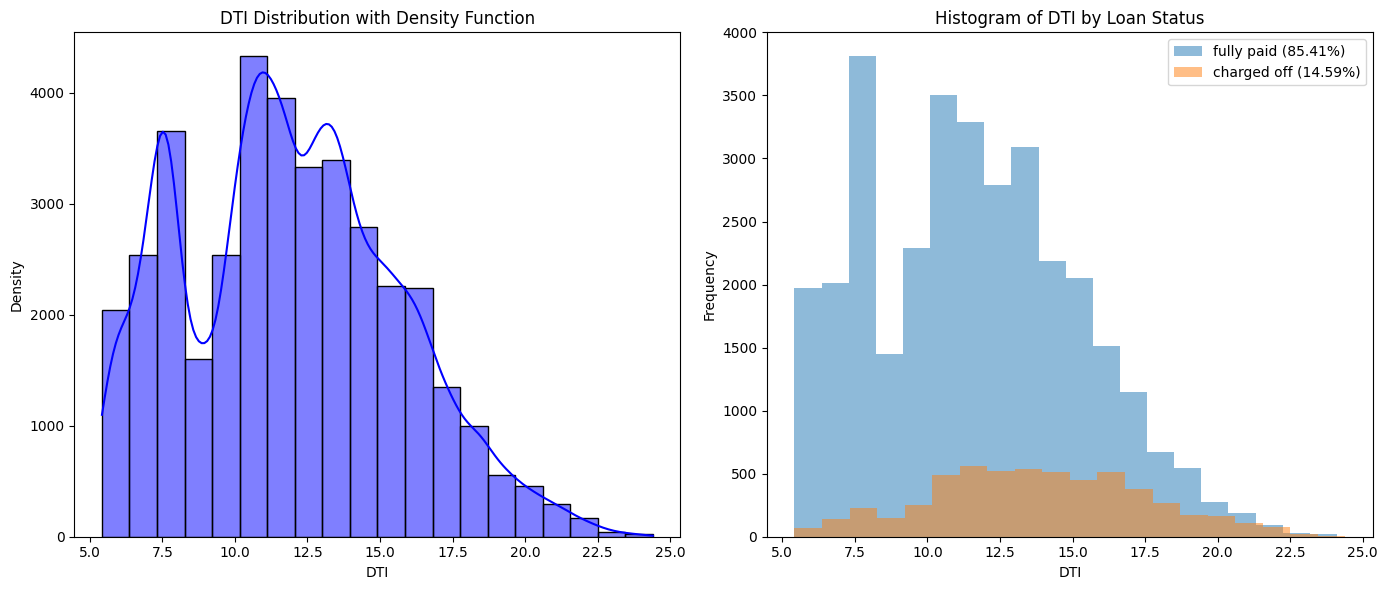

In [58]:
# Crear la figura y las subtramas en 1 fila y 2 columnas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Primer gráfico: histograma con función de densidad usando Seaborn
sns.histplot(df_final['interest_rate'], kde=True, bins=20, color='blue', ax=ax1)
ax1.set_xlabel('DTI')
ax1.set_ylabel('Density')
ax1.set_title('DTI Distribution with Density Function')

# Segundo gráfico: histograma de 'loan_amount' por 'loan_status'
status_counts = df_final['loan_status'].value_counts(normalize=True) * 100

for status in df_final['loan_status'].unique():
    loan_amounts = df_final[df_final['loan_status'] == status]['interest_rate']
    ax2.hist(loan_amounts, bins=20, alpha=0.5, label=f"{status} ({status_counts[status]:.2f}%)")

ax2.set_xlabel('DTI')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of DTI by Loan Status')
ax2.legend()

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos combinados
plt.show()

La siguiente gráfica en analizar será la misma relación, pero con la variable 'installment'

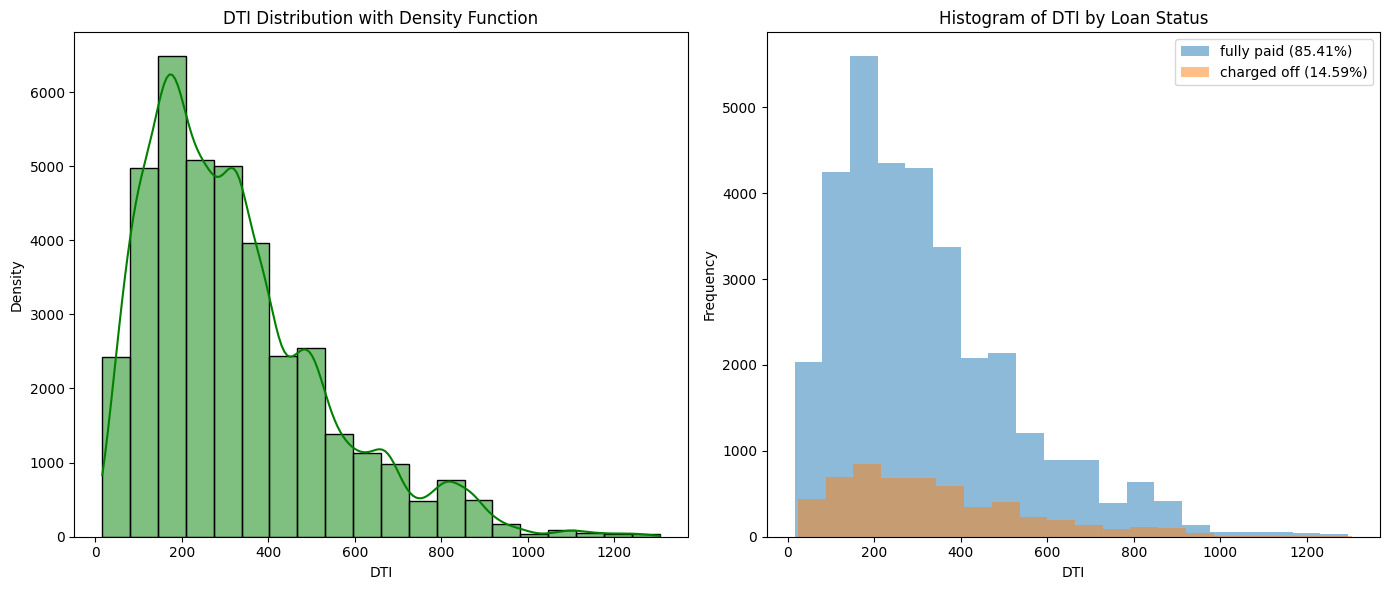

In [59]:
# Crear la figura y las subtramas en 1 fila y 2 columnas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Primer gráfico: histograma con función de densidad usando Seaborn
sns.histplot(df_final['installment'], kde=True, bins=20, color='green', ax=ax1)
ax1.set_xlabel('DTI')
ax1.set_ylabel('Density')
ax1.set_title('DTI Distribution with Density Function')

# Segundo gráfico: histograma de 'loan_amount' por 'loan_status'
status_counts = df_final['loan_status'].value_counts(normalize=True) * 100

for status in df_final['loan_status'].unique():
    loan_amounts = df_final[df_final['loan_status'] == status]['installment']
    ax2.hist(loan_amounts, bins=20, alpha=0.5, label=f"{status} ({status_counts[status]:.2f}%)")

ax2.set_xlabel('DTI')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of DTI by Loan Status')
ax2.legend()

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos combinados
plt.show()

Veamos ahora la relación con el "propósito" para el que fue solicitado el préstamo

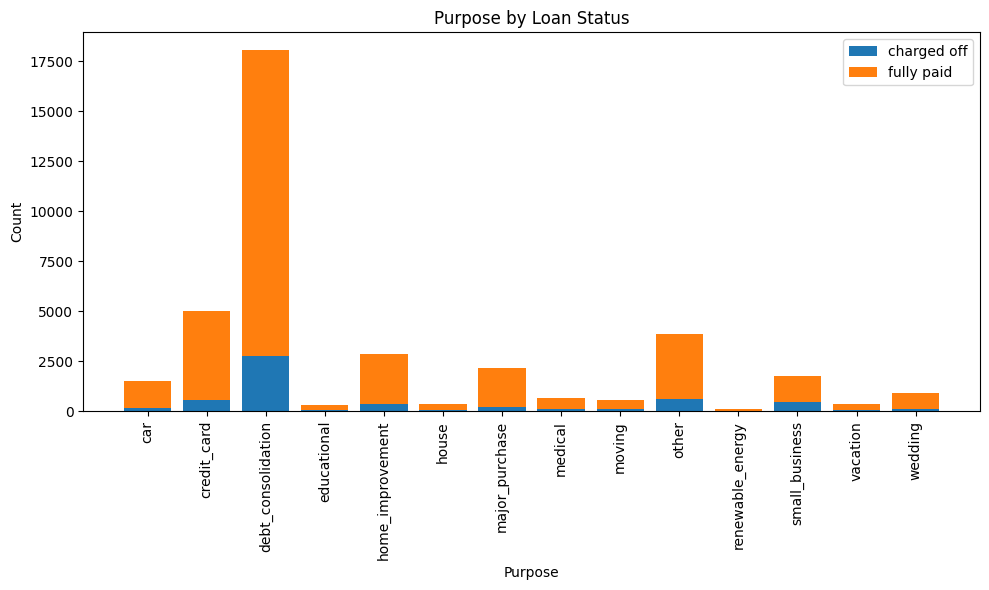

In [60]:
# Obtener el recuento de combinaciones 'purpose'-'loan_status'
grouped = df_final.groupby(['purpose', 'loan_status']).size().unstack()

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))

index = range(len(grouped))

# Iterar sobre cada tipo de 'purpose' y dibujar barras apiladas para cada tipo de 'loan_status'
bottoms = [0] * len(grouped)
for status in grouped.columns:
    ax.bar(index, grouped[status], label=status, bottom=bottoms)
    bottoms = [sum(x) for x in zip(bottoms, grouped[status])]

# Añadir etiquetas, título y leyenda
ax.set_xlabel('Purpose')
ax.set_ylabel('Count')
ax.set_title('Purpose by Loan Status')
ax.set_xticks(index)
ax.set_xticklabels(grouped.index, rotation=90)
ax.legend()

# Mostrar el gráfico de barras apiladas
plt.tight_layout()
plt.show()

Veamos los porcentajes realtivos para cada propósito

In [61]:
# Porcentajes relativos de cada valor de 'loan_status' por cada valor de 'loan_term'
grouped = df_final.groupby('purpose')['loan_status'].value_counts(normalize=True).unstack() * 100

print(grouped)

loan_status         charged off  fully paid
purpose                                    
car                   10.673783   89.326217
credit_card           10.781778   89.218222
debt_consolidation    15.325395   84.674605
educational           17.230769   82.769231
home_improvement      12.069565   87.930435
house                 16.076294   83.923706
major_purchase        10.325581   89.674419
medical               15.565345   84.434655
moving                15.972222   84.027778
other                 16.377749   83.622251
renewable_energy      18.627451   81.372549
small_business        27.080958   72.919042
vacation              14.133333   85.866667
wedding               10.367171   89.632829


Parece que el propósito para el que se solicita el préstamo podría tener incidencia en la probabilidad de impago del préstamo. 

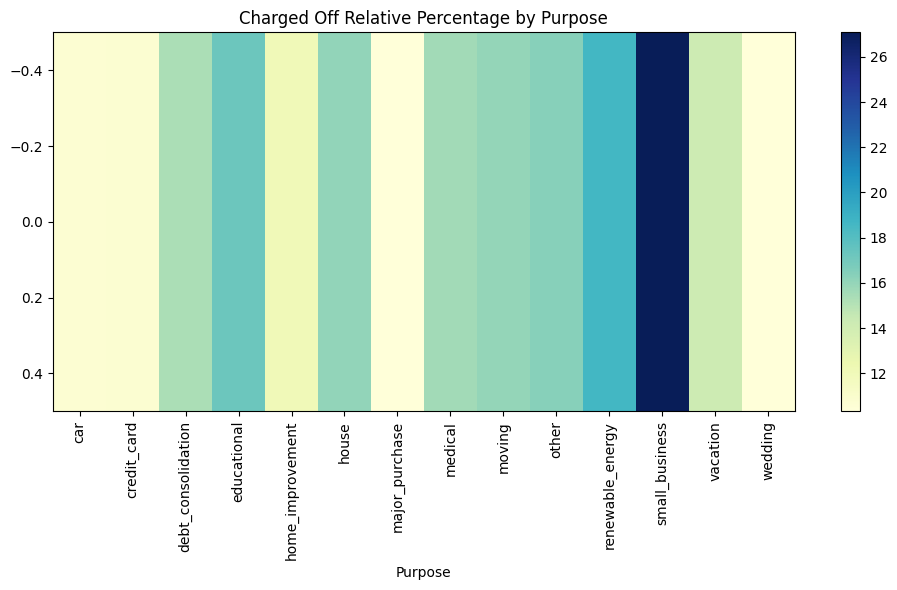

In [62]:
# Filtrar el DataFrame para 'loan_status' igual a 'charged off'
charged_off_df = df_final[df_final['loan_status'] == 'charged off']

# Obtener el recuento de combinaciones 'purpose'-'loan_status' igual a 'charged off'
grouped = charged_off_df.groupby('purpose')['loan_status'].count()

# Calcular los porcentajes relativos para cada valor de 'purpose'
relative_percentages = (grouped / df_final['purpose'].value_counts()) * 100

# Crear un DataFrame con los porcentajes relativos
relative_percentages_df = pd.DataFrame(relative_percentages, columns=['Charged Off Relative Percentage'])

# Crear un gráfico de calor
plt.figure(figsize=(10, 6))
heatmap = plt.imshow(relative_percentages_df.values.reshape(1, -1), cmap='YlGnBu', aspect='auto')

# Añadir etiquetas, título y colorbar
plt.xticks(range(len(relative_percentages_df)), relative_percentages_df.index, rotation=90)
plt.xlabel('Purpose')
plt.ylabel('')
plt.title('Charged Off Relative Percentage by Purpose')
plt.colorbar(heatmap)

plt.tight_layout()
plt.show()

En este mapa de calor puede apreciarse gráficamente el riesgo de impago del crédito según el propósito que tenga el mismo, teniendo el mayor valor en el caso de que sea para financiar pequeños negocios.

Veamos ahora la relación con el ratio 'dti'. El ratio 'dti' divide el total de cuotas pagadas por el prestatario, exceptuando la hipoteca, entre los ingresos totales de este.

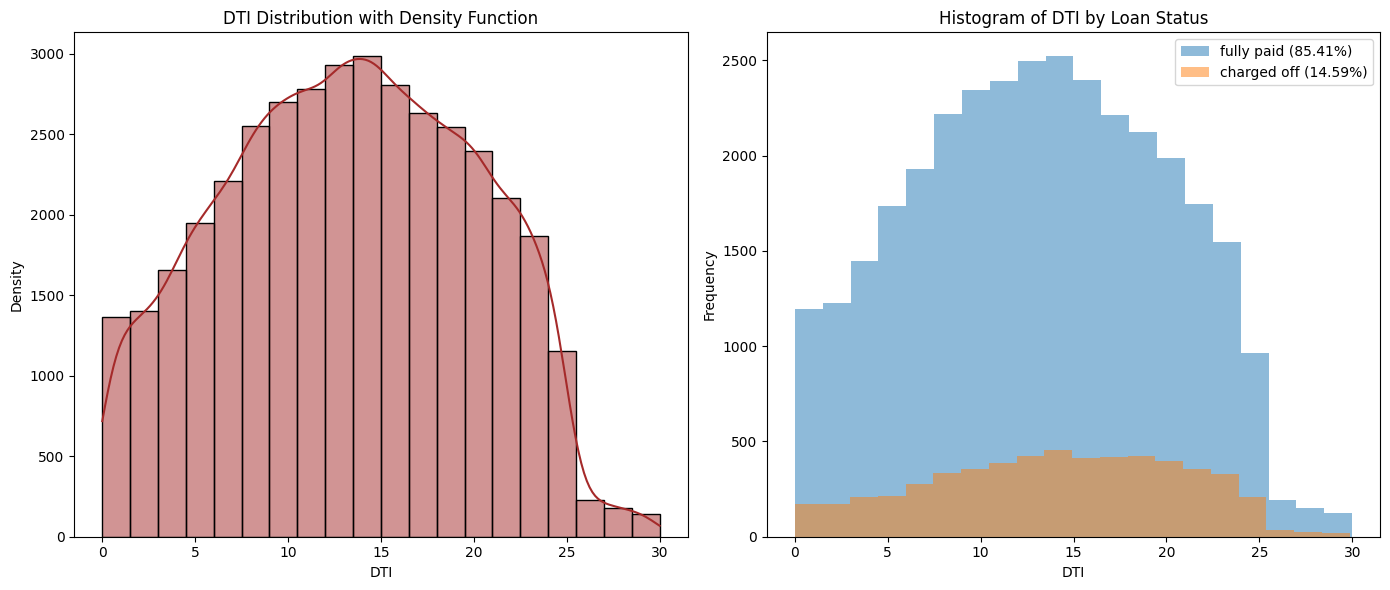

In [63]:
# Crear la figura y las subtramas en 1 fila y 2 columnas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Primer gráfico: histograma con función de densidad usando Seaborn
sns.histplot(df_final['dti'], kde=True, bins=20, color='brown', ax=ax1)
ax1.set_xlabel('DTI')
ax1.set_ylabel('Density')
ax1.set_title('DTI Distribution with Density Function')

# Segundo gráfico: histograma de 'loan_amount' por 'loan_status'
status_counts = df_final['loan_status'].value_counts(normalize=True) * 100

for status in df_final['loan_status'].unique():
    loan_amounts = df_final[df_final['loan_status'] == status]['dti']
    ax2.hist(loan_amounts, bins=20, alpha=0.5, label=f"{status} ({status_counts[status]:.2f}%)")

ax2.set_xlabel('DTI')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of DTI by Loan Status')
ax2.legend()

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos combinados
plt.show()

Analizamos ahora la variable 'revolving_rate'

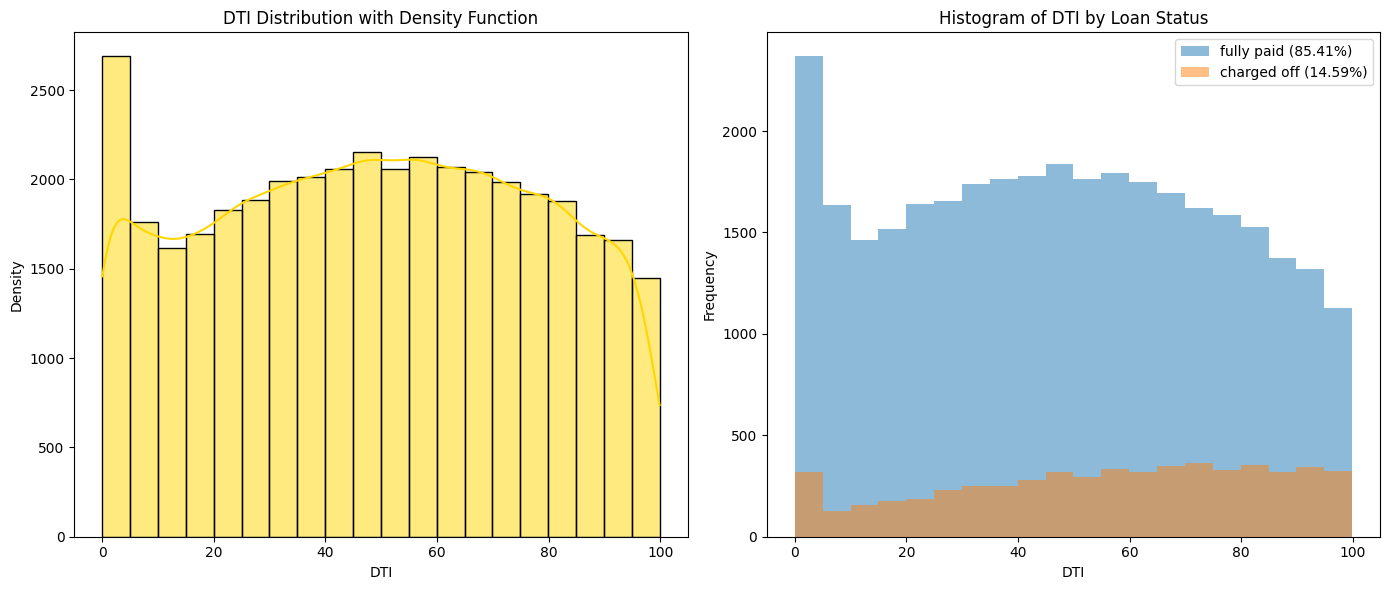

In [64]:
# Crear la figura y las subtramas en 1 fila y 2 columnas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Primer gráfico: histograma con función de densidad usando Seaborn
sns.histplot(df_final['revolving_rate'], kde=True, bins=20, color='gold', ax=ax1)
ax1.set_xlabel('DTI')
ax1.set_ylabel('Density')
ax1.set_title('DTI Distribution with Density Function')

# Segundo gráfico: histograma de 'loan_amount' por 'loan_status'
status_counts = df_final['loan_status'].value_counts(normalize=True) * 100

for status in df_final['loan_status'].unique():
    loan_amounts = df_final[df_final['loan_status'] == status]['revolving_rate']
    ax2.hist(loan_amounts, bins=20, alpha=0.5, label=f"{status} ({status_counts[status]:.2f}%)")

ax2.set_xlabel('DTI')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of DTI by Loan Status')
ax2.legend()

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos combinados
plt.show()

Hacemos el análisis con la variable 'employment_length'. Se trata de una variable numérica discreta. Le damos el mismo trato que si fuera una variable categórica. Hacemos el análisis distinguiendo si el préstamo ha sido o no pagado.

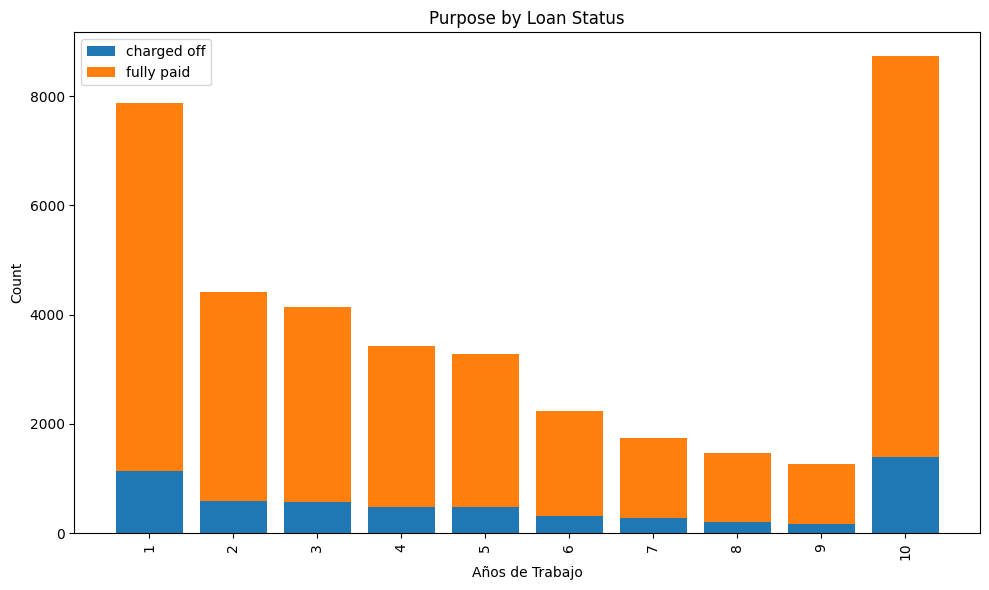

In [65]:
# Obtener el recuento de combinaciones 'purpose'-'loan_status'
grouped = df_final.groupby(['employment_length', 'loan_status']).size().unstack()

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))

index = range(len(grouped))

# Iterar sobre cada tipo de 'purpose' y dibujar barras apiladas para cada tipo de 'loan_status'
bottoms = [0] * len(grouped)
for status in grouped.columns:
    ax.bar(index, grouped[status], label=status, bottom=bottoms)
    bottoms = [sum(x) for x in zip(bottoms, grouped[status])]

# Añadir etiquetas, título y leyenda
ax.set_xlabel('Años de Trabajo')
ax.set_ylabel('Count')
ax.set_title('Purpose by Loan Status')
ax.set_xticks(index)
ax.set_xticklabels(grouped.index, rotation=90)
ax.legend()

# Mostrar el gráfico de barras apiladas
plt.tight_layout()
plt.show()

In [66]:
# Porcentajes relativos de cada valor de 'loan_status' por cada valor de 'loan_term'
grouped = df_final.groupby('employment_length')['loan_status'].value_counts(normalize=True).unstack() * 100

print(grouped)

loan_status        charged off  fully paid
employment_length                         
1                    14.523296   85.476704
2                    13.473732   86.526268
3                    13.967562   86.032438
4                    14.010508   85.989492
5                    14.655698   85.344302
6                    14.260170   85.739830
7                    15.560641   84.439359
8                    14.099932   85.900068
9                    13.191153   86.808847
10                   15.870835   84.129165


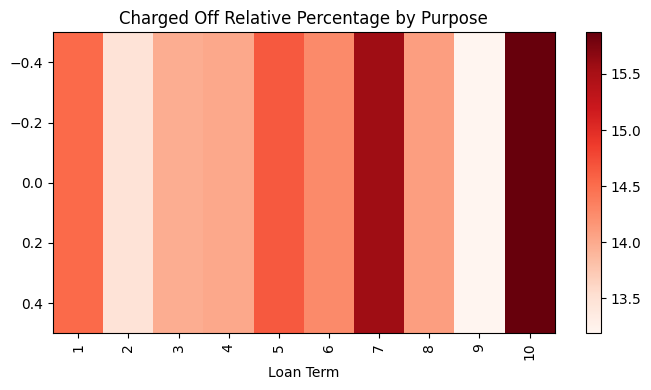

In [67]:
# Filtrar el DataFrame para 'loan_status' igual a 'charged off'
charged_off_df = df_final[df_final['loan_status'] == 'charged off']

# Obtener el recuento de combinaciones 'purpose'-'loan_status' igual a 'charged off'
grouped = charged_off_df.groupby('employment_length')['loan_status'].count()

# Calcular los porcentajes relativos para cada valor de 'purpose'
relative_percentages = (grouped / df_final['employment_length'].value_counts()) * 100

# Crear un DataFrame con los porcentajes relativos
relative_percentages_df = pd.DataFrame(relative_percentages, columns=['Charged Off Relative Percentage'])

# Crear un gráfico de calor
plt.figure(figsize=(7, 4))
heatmap = plt.imshow(relative_percentages_df.values.reshape(1, -1), aspect='auto', cmap='Reds')

# Añadir etiquetas, título y colorbar
plt.xticks(range(len(relative_percentages_df)), relative_percentages_df.index, rotation=90)
plt.xlabel('Loan Term')
plt.ylabel('')
plt.title('Charged Off Relative Percentage by Purpose')
plt.colorbar(heatmap)

plt.tight_layout()
plt.show()

Aunque no hay grandes diferencias en los porcentajes de impago según los años que lleba el arrendatario trabajando, sí parece que hay cierta proporción mayor entre los que llevan 7 años y más de 10 años trabajando.

La siguiente variable a estudiar es el tipo de propiedad sobre la vivienda.

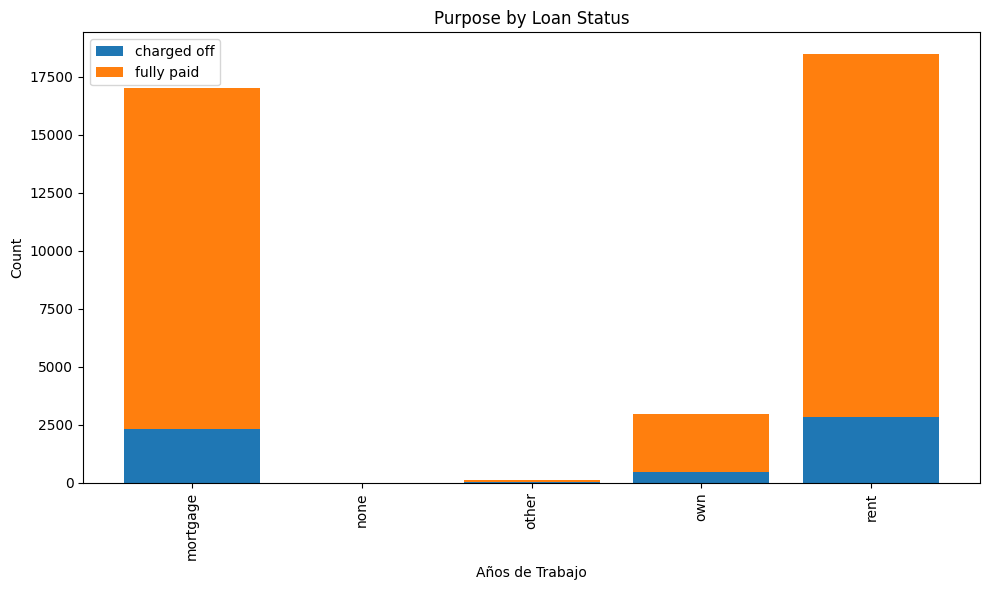

In [68]:
# Obtener el recuento de combinaciones 'purpose'-'loan_status'
grouped = df_final.groupby(['home_ownership', 'loan_status']).size().unstack()

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))

index = range(len(grouped))

# Iterar sobre cada tipo de 'purpose' y dibujar barras apiladas para cada tipo de 'loan_status'
bottoms = [0] * len(grouped)
for status in grouped.columns:
    ax.bar(index, grouped[status], label=status, bottom=bottoms)
    bottoms = [sum(x) for x in zip(bottoms, grouped[status])]

# Añadir etiquetas, título y leyenda
ax.set_xlabel('Años de Trabajo')
ax.set_ylabel('Count')
ax.set_title('Purpose by Loan Status')
ax.set_xticks(index)
ax.set_xticklabels(grouped.index, rotation=90)
ax.legend()

# Mostrar el gráfico de barras apiladas
plt.tight_layout()
plt.show()

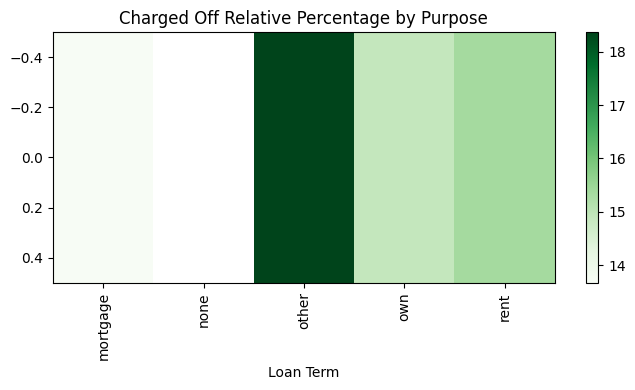

In [69]:
# Filtrar el DataFrame para 'loan_status' igual a 'charged off'
charged_off_df = df_final[df_final['loan_status'] == 'charged off']

# Obtener el recuento de combinaciones 'purpose'-'loan_status' igual a 'charged off'
grouped = charged_off_df.groupby('home_ownership')['loan_status'].count()

# Calcular los porcentajes relativos para cada valor de 'purpose'
relative_percentages = (grouped / df_final['home_ownership'].value_counts()) * 100

# Crear un DataFrame con los porcentajes relativos
relative_percentages_df = pd.DataFrame(relative_percentages, columns=['Charged Off Relative Percentage'])

# Crear un gráfico de calor
plt.figure(figsize=(7, 4))
heatmap = plt.imshow(relative_percentages_df.values.reshape(1, -1), aspect='auto', cmap='Greens')

# Añadir etiquetas, título y colorbar
plt.xticks(range(len(relative_percentages_df)), relative_percentages_df.index, rotation=90)
plt.xlabel('Loan Term')
plt.ylabel('')
plt.title('Charged Off Relative Percentage by Purpose')
plt.colorbar(heatmap)

plt.tight_layout()
plt.show()

Si bien el apartado de 'otros' es el que parece tener mayor porcentaje de impagados, es una variable muy poco representativa del total de préstamos. Tener la vivienda en alquiler, seguida de en propiedad parecen tener más incidencia en los impagos de un préstamo.

La última variable que vamos a analizar son los ingresos anuales

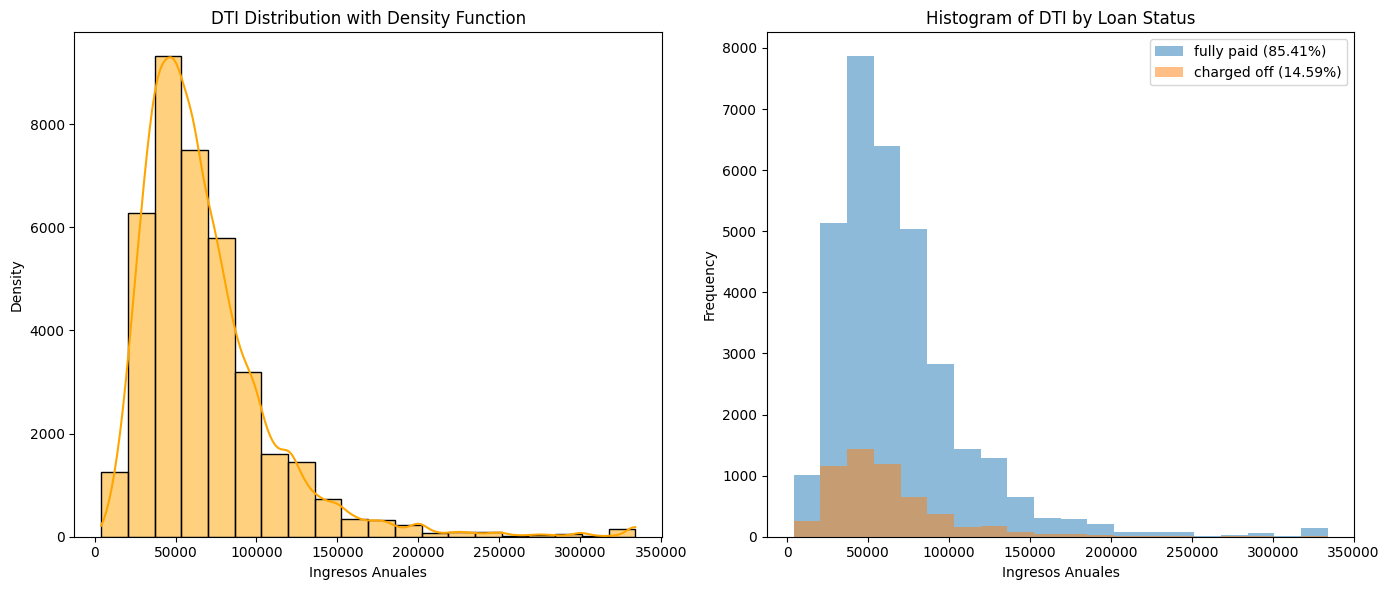

In [70]:
# Crear la figura y las subtramas en 1 fila y 2 columnas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Primer gráfico: histograma con función de densidad usando Seaborn
sns.histplot(df_final['annual_income'], kde=True, bins=20, color='orange', ax=ax1)
ax1.set_xlabel('Ingresos Anuales')
ax1.set_ylabel('Density')
ax1.set_title('DTI Distribution with Density Function')

# Segundo gráfico: histograma de 'loan_amount' por 'loan_status'
status_counts = df_final['loan_status'].value_counts(normalize=True) * 100

for status in df_final['loan_status'].unique():
    loan_amounts = df_final[df_final['loan_status'] == status]['annual_income']
    ax2.hist(loan_amounts, bins=20, alpha=0.5, label=f"{status} ({status_counts[status]:.2f}%)")

ax2.set_xlabel('Ingresos Anuales')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of DTI by Loan Status')
ax2.legend()

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos combinados
plt.show()

## Análisis Multivariante

Veamos en primer lugar la correlación existente entre las variables numéricas de nuestro dataset

In [71]:
columnas_estudio = [    
    'loan_amount',
    'interest_rate',
    'installment',
    'revolving_rate',
    'annual_income',
    'dti']

correlation_matrix = df_final[columnas_estudio].corr()
correlation_matrix

,loan_amount,interest_rate,installment,revolving_rate,annual_income,dti
loan_amount,1.000000,0.301265,0.932260,0.065247,0.401889,0.062436
interest_rate,0.301265,1.000000,0.277203,0.463627,0.076372,0.110913
installment,0.932260,0.277203,1.000000,0.094559,0.402393,0.052038
revolving_rate,0.065247,0.463627,0.094559,1.000000,0.035024,0.279091
annual_income,0.401889,0.076372,0.402393,0.035024,1.000000,-0.140892
dti,0.062436,0.110913,0.052038,0.279091,-0.140892,1.000000


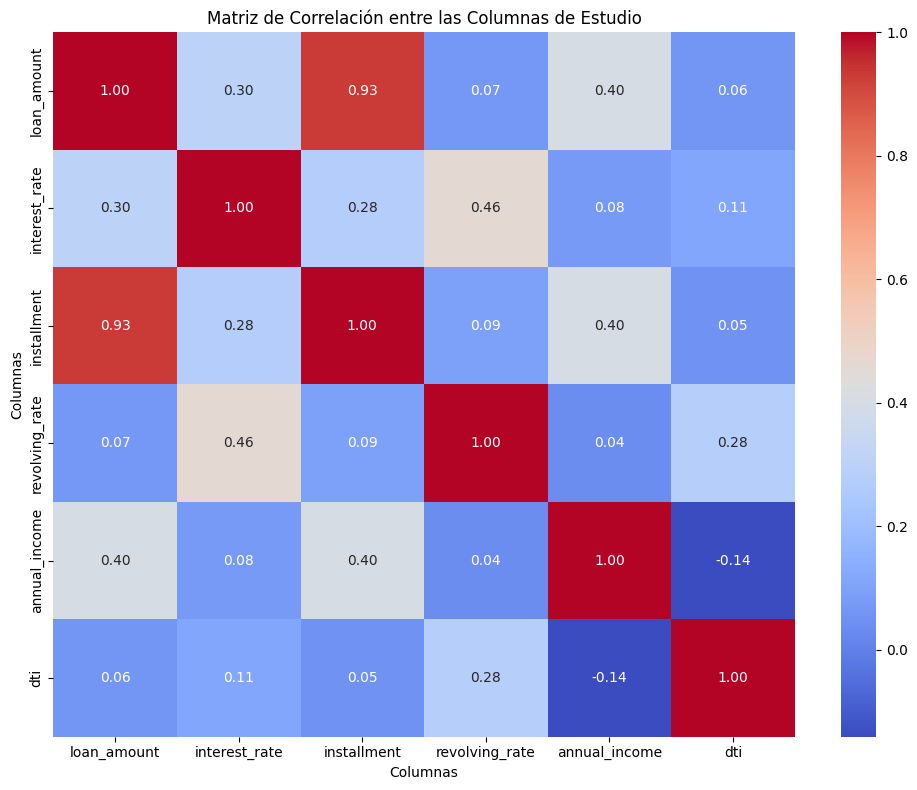

In [72]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre las Columnas de Estudio')
plt.xlabel('Columnas')
plt.ylabel('Columnas')
plt.tight_layout()
plt.show()

Como vemos la correlación entre las variables numéricas es muy baja, con la excepción de la correlación entre el importe del préstamo y la cuota pagada (lo cual tiene todo el sentido).

Cabe mencionar alguna relación entre el tipo de interés y la tasa de revolving, entre los ingresos anuales y la cuota pagada, y entre los ingresos anuales y el importe del préstamo

Vemos gráficamente estas realciones

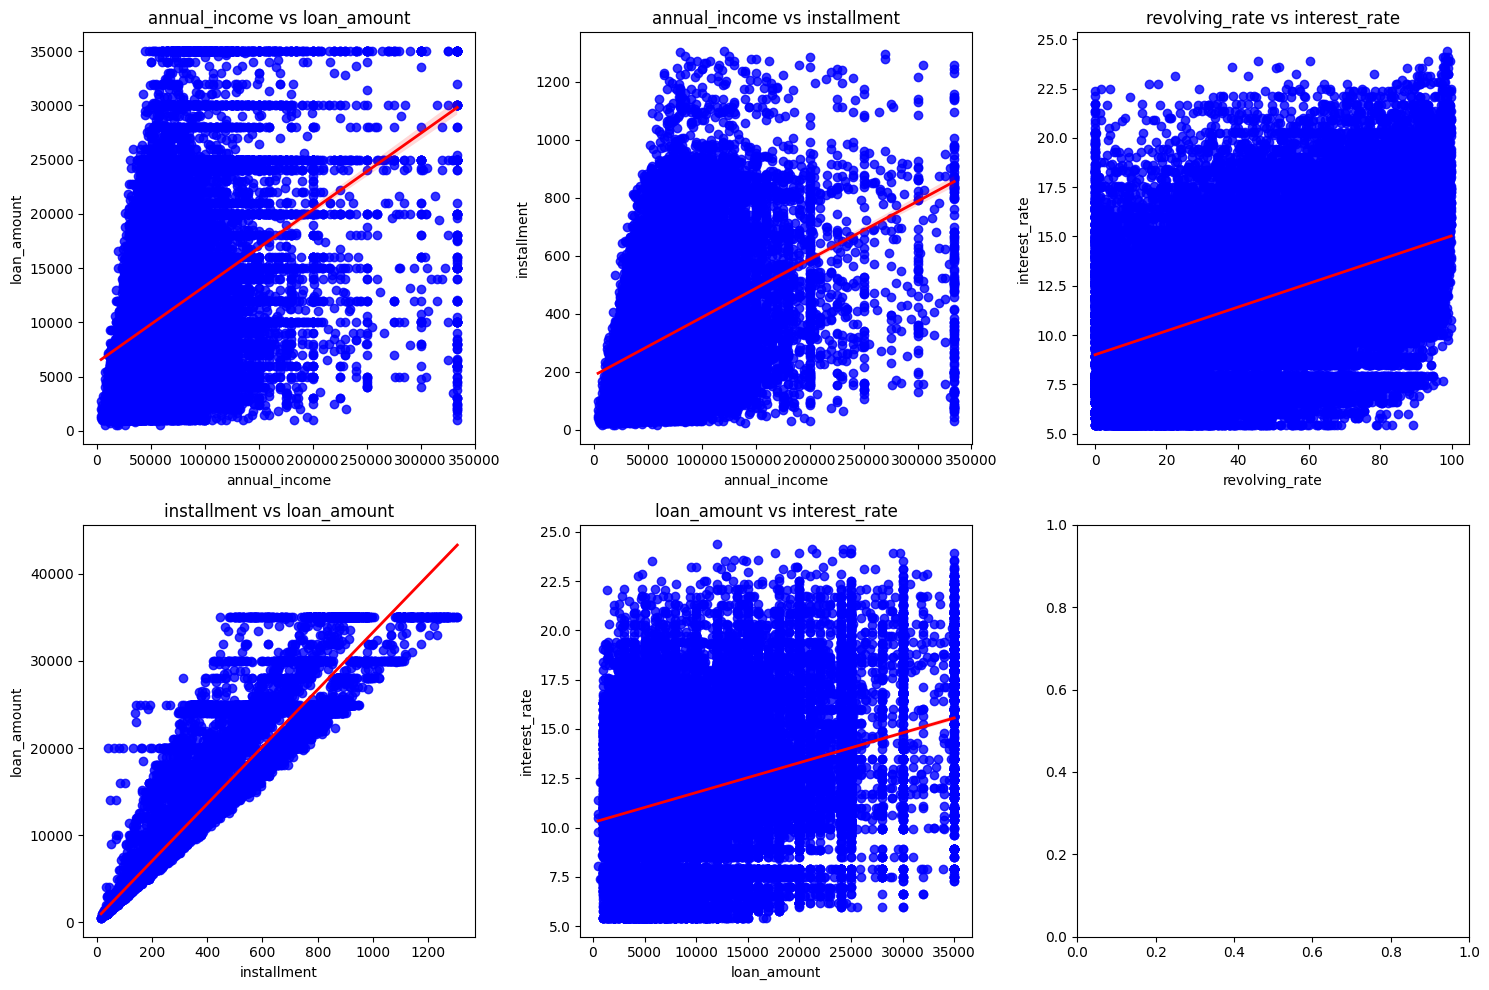

In [73]:
# Definir las columnas para el estudio
columnas_estudio = ['loan_amount', 'interest_rate', 'installment', 'revolving_rate', 'annual_income', 'dti']

# Seleccionar solo las columnas de interés del DataFrame
df_estudio = df_final[columnas_estudio]

# Crear un subplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Definir las combinaciones de columnas y sus posiciones en el subplot
columnas_combinaciones = [
    ('annual_income', 'loan_amount'),
    ('annual_income', 'installment'),
    ('revolving_rate', 'interest_rate'),
    ('installment', 'loan_amount'),
    ('loan_amount', 'interest_rate')
]

# Iterar sobre las combinaciones y trazar gráficos de dispersión con línea de tendencia
for i, combinacion in enumerate(columnas_combinaciones):
    row = i // 3
    col = i % 3
    sns.regplot(x=combinacion[0], y=combinacion[1], data=df_estudio, ax=axs[row, col], scatter_kws={"color": "blue"}, line_kws={"color":"red","linewidth":2})
    axs[row, col].set_title(f'{combinacion[0]} vs {combinacion[1]}')

# Ajustar diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

## Hipótesis de Desarrollo

La primera hipótesis es averiguar si el importe del préstamo tienen una incidencia significativa en el impago del mismo

'loan_amount' vs 'loan_status' ----> T de Student

H0: No hay evidencia significativa de que el importe del préstamo incide en el impago del mismo

H1: Hay una incidencia significativa en que el importe del préstamo incide en el impago del mismo

In [74]:
df_final_paid = df_final[df_final['loan_status'] == 'fully paid']
df_final_charged_off = df_final[df_final['loan_status'] == 'charged off']
df_final_paid.to_csv('../data/process/df_final_paid.csv', index=False)
df_final_charged_off.to_csv('../data/process/df_final_charged_off.csv', index=False)

from scipy.stats import ttest_ind

# Realizar la prueba de t de Student para comparar las medias de 'loan_amount' entre 'fully paid' y 'charged off'
t_statistic, p_value = ttest_ind(df_final_paid['loan_amount'], df_final_charged_off['loan_amount'], equal_var=False)

# Imprimir el resultado del contraste de hipótesis
print(f"Estadístico t: {t_statistic}")
print(f"Valor p: {p_value}")
if p_value < 0.05:
    print("Se rechaza la hipótesis nula: 'loan_amount' incide en 'loan_status'")
else:
    print("No se puede rechazar la hipótesis nula: 'loan_amount' no incide en 'loan_status'")

Estadístico t: -10.778079251874532
Valor p: 6.987968294434883e-27
Se rechaza la hipótesis nula: 'loan_amount' incide en 'loan_status'


La siguiente hipótesis es averiguar si el tipo de interés tienen una incidencia significativa en el impago del mismo

'interest_rate' vs 'loan_status' ----> T de Student

H0: No hay evidencia significativa de que el tipo de interés incide en el impago del mismo

H1: Hay una incidencia significativa en que el tipo de interés incide en el impago del mismo

In [75]:
# Realizar la prueba t de Student
t_statistic, p_value = ttest_ind(df_final_paid['interest_rate'], df_final_charged_off['interest_rate'], equal_var=False)

# Imprimir los resultados del contraste de hipótesis
print(f"Estadístico t: {t_statistic}")
print(f"Valor p: {p_value}")
if p_value < 0.05:
    print("Se rechaza la hipótesis nula: 'interest_rate' incide en 'loan_status'")
else:
    print("No se puede rechazar la hipótesis nula: 'interest_rate' no incide en 'loan_status'")

Estadístico t: -42.028825622437054
Valor p: 0.0
Se rechaza la hipótesis nula: 'interest_rate' incide en 'loan_status'


La siguiente hipótesis es averiguar si el importe de la cuota tienen una incidencia significativa en el impago del mismo

'installment' vs 'loan_status' ----> T de Student

H0: No hay evidencia significativa de que el importe de la cuota incide en el impago del mismo

H1: Hay una incidencia significativa en que el importe de la cuota incide en el impago del mismo

In [76]:
# Realizar la prueba t de Student
t_statistic, p_value = ttest_ind(df_final_paid['installment'], df_final_charged_off['installment'], equal_var=False)

# Imprimir los resultados del contraste de hipótesis
print(f"Estadístico t: {t_statistic}")
print(f"Valor p: {p_value}")
if p_value < 0.05:
    print("Se rechaza la hipótesis nula: 'installment' incide en 'loan_status'")
else:
    print("No se puede rechazar la hipótesis nula: 'installment' no incide en 'loan_status'")

Estadístico t: -5.1602335637612
Valor p: 2.529850741459151e-07
Se rechaza la hipótesis nula: 'installment' incide en 'loan_status'


La siguiente hipótesis es averiguar si el ratio DTI tienen una incidencia significativa en el impago del mismo

'dti' vs 'loan_status' ----> T de Student

H0: No hay evidencia significativa de que el ratio DTI incide en el impago del mismo

H1: Hay una incidencia significativa en que el ratio DTI incide en el impago del mismo

In [77]:
# Realizar la prueba t de Student
t_statistic, p_value = ttest_ind(df_final_paid['dti'], df_final_charged_off['dti'], equal_var=False)

# Imprimir los resultados del contraste de hipótesis
print(f"Estadístico t: {t_statistic}")
print(f"Valor p: {p_value}")
if p_value < 0.05:
    print("Se rechaza la hipótesis nula: 'dti' incide en 'loan_status'")
else:
    print("No se puede rechazar la hipótesis nula: 'dti' no incide en 'loan_status'")

Estadístico t: -8.95236258997726
Valor p: 4.298113418045924e-19
Se rechaza la hipótesis nula: 'dti' incide en 'loan_status'


La siguiente hipótesis es averiguar si el grado de uso de las tarjetas revolving tienen una incidencia significativa en el impago del mismo

'revolving_rate' vs 'loan_status' ----> T de Student

H0: No hay evidencia significativa de que el el grado de uso de las tarjetas revolving incide en el impago del mismo

H1: Hay una incidencia significativa en que el grado de uso de las tarjetas revolving incide en el impago del mismo

In [78]:
# Realizar la prueba t de Student
t_statistic, p_value = ttest_ind(df_final_paid['revolving_rate'], df_final_charged_off['revolving_rate'], equal_var=False)

# Imprimir los resultados del contraste de hipótesis
print(f"Estadístico t: {t_statistic}")
print(f"Valor p: {p_value}")
if p_value < 0.05:
    print("Se rechaza la hipótesis nula: 'revolving_rate' incide en 'loan_status'")
else:
    print("No se puede rechazar la hipótesis nula: 'revolving_rate' no incide en 'loan_status'")

Estadístico t: -19.59329527608322
Valor p: 1.8374326096484966e-83
Se rechaza la hipótesis nula: 'revolving_rate' incide en 'loan_status'


La siguiente hipótesis es averiguar si el el tiempo que lleva empleado tienen una incidencia significativa en el impago del mismo

'employment_length' vs 'loan_status' ----> T de Student

H0: No hay evidencia significativa de que el el tiempo que lleva empleado incide en el impago del mismo

H1: Hay una incidencia significativa en que el tiempo que lleva empleado incide en el impago del mismo

In [79]:
# Realizar la prueba t de Student
t_statistic, p_value = ttest_ind(df_final_paid['revolving_rate'], df_final_charged_off['revolving_rate'], equal_var=False)

# Imprimir los resultados del contraste de hipótesis
print(f"Estadístico t: {t_statistic}")
print(f"Valor p: {p_value}")
if p_value < 0.05:
    print("Se rechaza la hipótesis nula: 'employment_length' incide en 'loan_status'")
else:
    print("No se puede rechazar la hipótesis nula: 'employment_length' no incide en 'loan_status'")

Estadístico t: -19.59329527608322
Valor p: 1.8374326096484966e-83
Se rechaza la hipótesis nula: 'employment_length' incide en 'loan_status'


La siguiente hipótesis es averiguar si el el el régimen de vivienda tienen una incidencia significativa en el impago del mismo

'home_ownership' vs 'loan_status' ----> Prueba de independencia de Chi-Cuadrado

H0: No hay evidencia significativa de que el el régimen de vivienda incide en el impago del mismo

H1: Hay una incidencia significativa en que el régimen de vivienda incide en el impago del mismo

In [80]:
from scipy.stats import chi2_contingency

# Crear una tabla de contingencia entre 'home_ownership' y 'loan_status'
contingency_table = pd.crosstab(df_final['home_ownership'], df_final['loan_status'])

# Realizar la prueba de chi-cuadrado
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Imprimir los resultados del contraste de hipótesis
print(f"Estadístico Chi-cuadrado: {chi2}")
print(f"Valor p: {p_value}")
if p_value < 0.05:
    print("Se rechaza la hipótesis nula: 'home_ownership' incide en 'loan_status'")
else:
    print("No se puede rechazar la hipótesis nula: 'home_ownership' no incide en 'loan_status'")

Estadístico Chi-cuadrado: 22.232937426753175
Valor p: 0.00018011714098862449
Se rechaza la hipótesis nula: 'home_ownership' incide en 'loan_status'


La siguiente hipótesis es averiguar si el propósito para el que se concede el préstamo tienen una incidencia significativa en el impago del mismo

'purpose' vs 'loan_status' ----> Prueba de independencia de Chi-Cuadrado

H0: No hay evidencia significativa de que el propósito para el que se concede el préstamo incide en el impago del mismo

H1: Hay una incidencia significativa en que el propósito para el que se concede el préstamo incide en el impago del mismo

In [81]:
# Crear una tabla de contingencia entre 'home_ownership' y 'loan_status'
contingency_table = pd.crosstab(df_final['purpose'], df_final['loan_status'])

# Realizar la prueba de chi-cuadrado
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Imprimir los resultados del contraste de hipótesis
print(f"Estadístico Chi-cuadrado: {chi2}")
print(f"Valor p: {p_value}")
if p_value < 0.05:
    print("Se rechaza la hipótesis nula: 'purpose' incide en 'loan_status'")
else:
    print("No se puede rechazar la hipótesis nula: 'purpose' no incide en 'loan_status'")

Estadístico Chi-cuadrado: 378.9439492892116
Valor p: 6.213959204644354e-73
Se rechaza la hipótesis nula: 'purpose' incide en 'loan_status'


La última hipótesis es averiguar si los ingresos anuales tienen una incidencia significativa en el impago del mismo

'annual_income' vs 'loan_status' ----> Prueba de t de Student

H0: No hay evidencia significativa de que los ingresos anuales incide en el impago del mismo

H1: Hay una incidencia significativa en que los ingresos anuales incide en el impago del mismo

In [82]:
# Realizar la prueba t de Student
t_statistic, p_value = ttest_ind(df_final_paid['annual_income'], df_final_charged_off['annual_income'], equal_var=False)

# Imprimir los resultados del contraste de hipótesis
print(f"Estadístico t: {t_statistic}")
print(f"Valor p: {p_value}")
if p_value < 0.05:
    print("Se rechaza la hipótesis nula: 'annual_income' incide en 'loan_status'")
else:
    print("No se puede rechazar la hipótesis nula: 'annual_income' no incide en 'loan_status'")

Estadístico t: 12.352231910895293
Valor p: 9.71818129715952e-35
Se rechaza la hipótesis nula: 'annual_income' incide en 'loan_status'


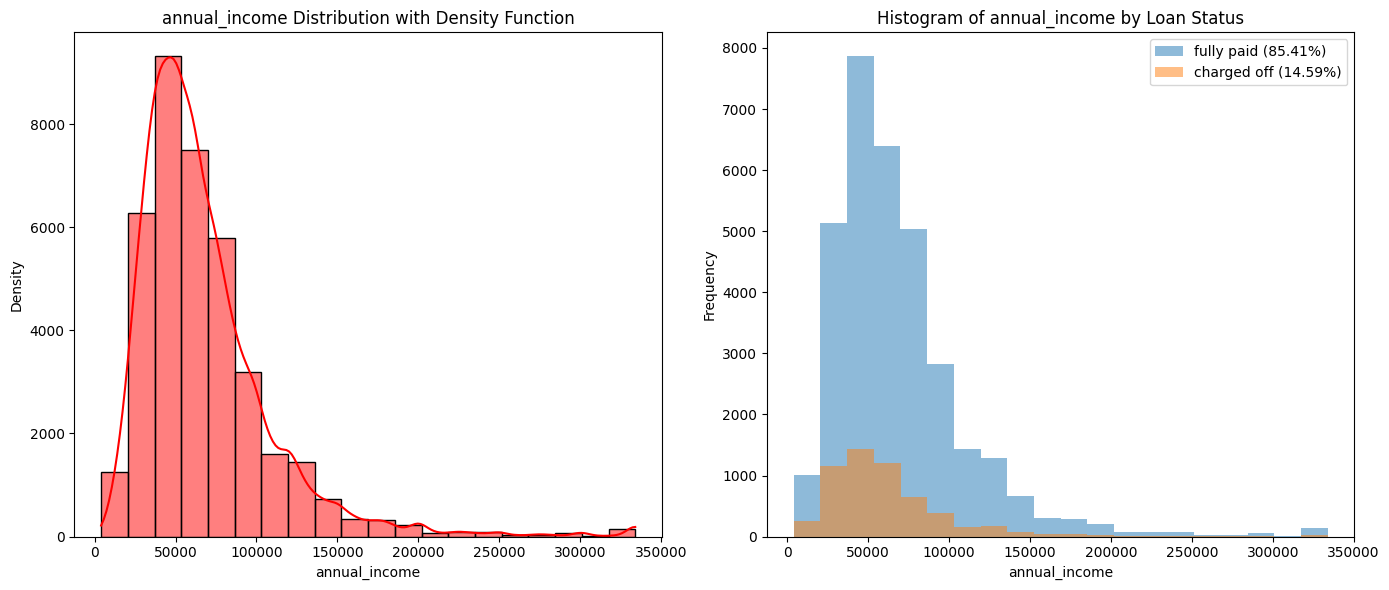

In [83]:
def graficos_var_cont(df, column_df):

    # Crear la figura y las subtramas en 1 fila y 2 columnas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Primer gráfico: histograma con función de densidad usando Seaborn
    sns.histplot(df[column_df], kde=True, bins=20, color='red', ax=ax1)
    ax1.set_xlabel(f'{column_df}')
    ax1.set_ylabel('Density')
    ax1.set_title(f'{column_df} Distribution with Density Function')

    # Segundo gráfico: histograma de 'loan_amount' por 'loan_status'
    status_counts = df['loan_status'].value_counts(normalize=True) * 100

    for status in df['loan_status'].unique():
        loan_amounts = df[df['loan_status'] == status][column_df]
        ax2.hist(loan_amounts, bins=20, alpha=0.5, label=f"{status} ({status_counts[status]:.2f}%)")

    ax2.set_xlabel(f'{column_df}')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Histogram of {column_df} by Loan Status')
    ax2.legend()

    # Ajustar espaciado entre subplots
    plt.tight_layout()

    # Mostrar los gráficos combinados
    plt.show()

graficos_var_cont(df_final, 'annual_income')

In [84]:
import sys
sys.path.append('../')

In [85]:
from utils.eda_functions import mapa_calor_impagados

In [86]:
def mapa_calor(df, col_heatmap):
    
    # Filtrar el DataFrame para 'loan_status' igual a 'charged off'
    charged_off_df = df[df['loan_status'] == 'charged off']

    # Obtener el recuento de combinaciones 'purpose'-'loan_status' igual a 'charged off'
    grouped = charged_off_df.groupby(col_heatmap)['loan_status'].count()

    # Calcular los porcentajes relativos para cada valor de 'purpose'
    relative_percentages = (grouped / df[col_heatmap].value_counts()) * 100

    # Crear un DataFrame con los porcentajes relativos
    relative_percentages_df = pd.DataFrame(relative_percentages, columns=['Charged Off Relative Percentage'])

    # Crear un gráfico de calor
    plt.figure(figsize=(7, 4))
    heatmap = plt.imshow(relative_percentages_df.values.reshape(1, -1), aspect='auto', cmap='Greens')

    # Añadir etiquetas, título y colorbar
    plt.xticks(range(len(relative_percentages_df)), relative_percentages_df.index, rotation=90)
    plt.xlabel(col_heatmap)
    plt.ylabel('')
    plt.title('Charged Off Relative Percentage by Purpose')
    plt.colorbar(heatmap)

    plt.tight_layout()
    plt.show()

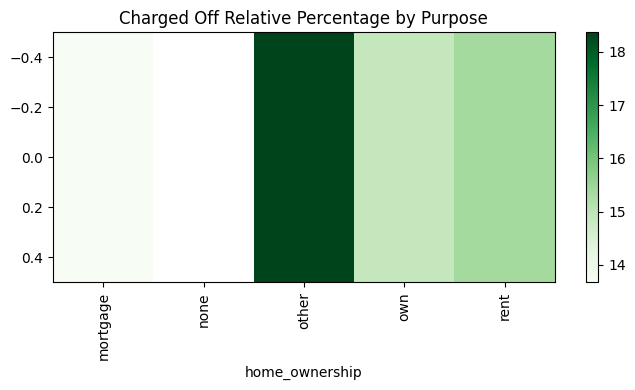

In [87]:
mapa_calor(df_final, 'home_ownership')

In [98]:
import sys
sys.path.append('../')

In [99]:
from utils.eda_functions import graficos_var_cont

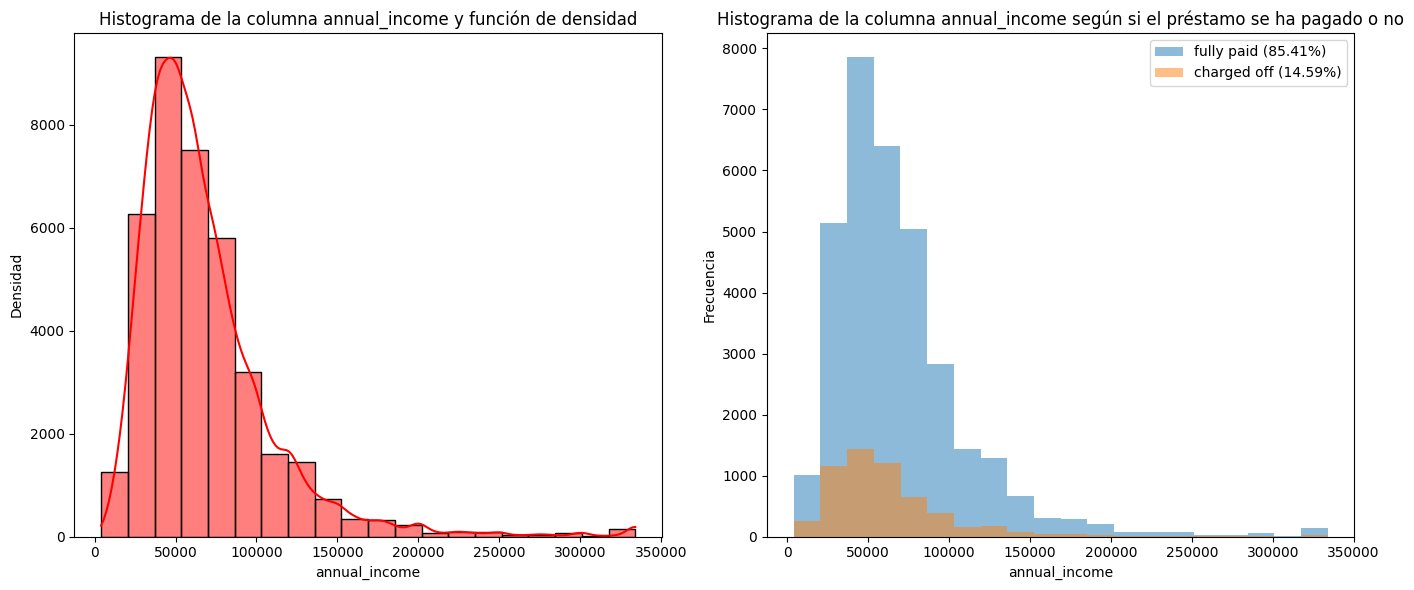

In [100]:
graficos_var_cont(df_final, 'annual_income', color='red')

In [102]:
from utils.eda_functions import grafico_mapa_calor_impagados

ImportError: cannot import name 'grafico_mapa_calor_impagados' from 'utils.eda_functions' (c:\Users\manue\OneDrive\Documentos\GitHub\EDA_Loans_DS\src\notebooks\..\utils\eda_functions.py)

In [103]:
grafico_mapa_calor_impagados(df_final, 'home_ownership', 'Greens')

NameError: name 'grafico_mapa_calor_impagados' is not defined